## Load and preprocess temperature data

In [ ]:
# Import necessary libraries
import pandas as pd # Imports the pandas library for data manipulation and analysis.
import os # Imports the os module for interacting with the operating system, used for path operations.
import matplotlib.pyplot as plt # Imports the matplotlib.pyplot module for creating visualizations.
import seaborn as sns # Imports the seaborn library for enhanced statistical data visualization.

In [ ]:
# --- Step 1: Define location and path ---
location = "19.32_72.72" # Defines the geographical coordinates for the data location.
data_root = "/content/drive/MyDrive/Dataset/Data/tmp" # Defines the base directory where the yearly data folders are stored in Google Drive.
years = [str(year) for year in range(1996, 2020)] # Creates a list of year strings from 1996 to 2019.

# --- Step 2: Read and combine all files for this location ---
df_list = [] # Initializes an empty list to hold DataFrames from each year.

for year in years: # Loops through each year in the 'years' list.
    # Constructs the full file path for the CSV file of the current year and location.
    file_path = os.path.join(data_root, year, f"{year}_{location}.csv")
    if os.path.exists(file_path): # Checks if the file exists at the constructed path.
        df_year = pd.read_csv(file_path) # Reads the CSV file into a pandas DataFrame.
        df_list.append(df_year) # Appends the DataFrame to the list.

# Combine all yearly DataFrames into one DataFrame.
df_temp = pd.concat(df_list, ignore_index=True) # Concatenates all DataFrames in df_list, resetting the index.

# --- Step 3: Preprocess the time column ---
# Converts the 'Time' column to datetime objects for time series analysis.
df_temp['Time'] = pd.to_datetime(df_temp['Time'])
df_temp.set_index('Time', inplace=True) # Sets the 'Time' column as the DataFrame's index.
df_temp.sort_index(inplace=True) # Sorts the DataFrame by the time index to ensure chronological order.

Missing values: 0 (0.00%)


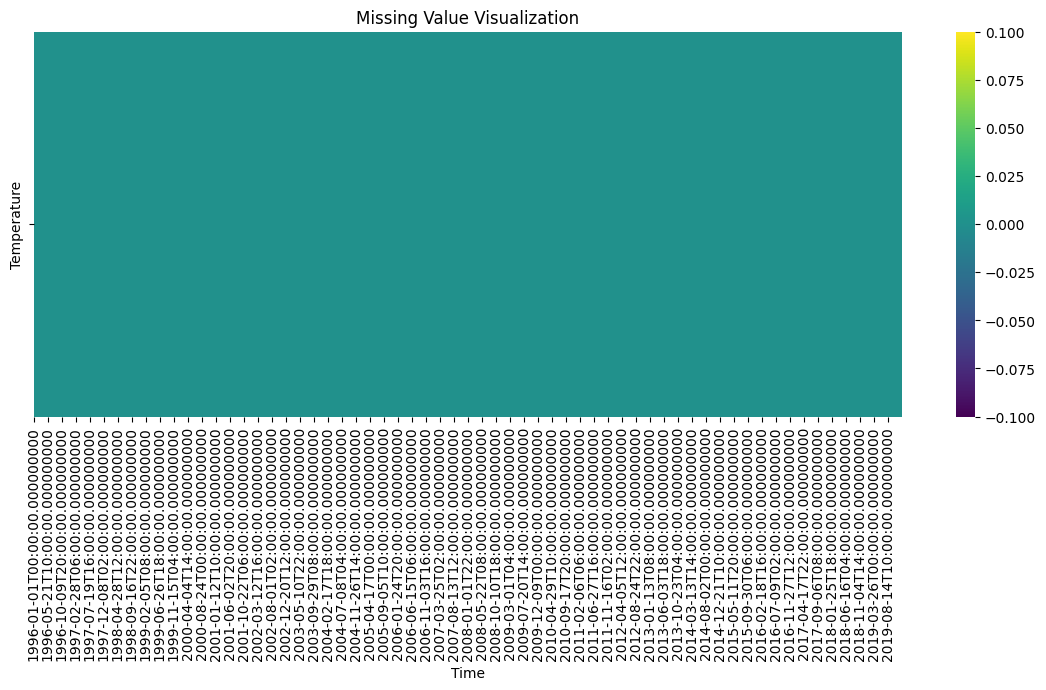

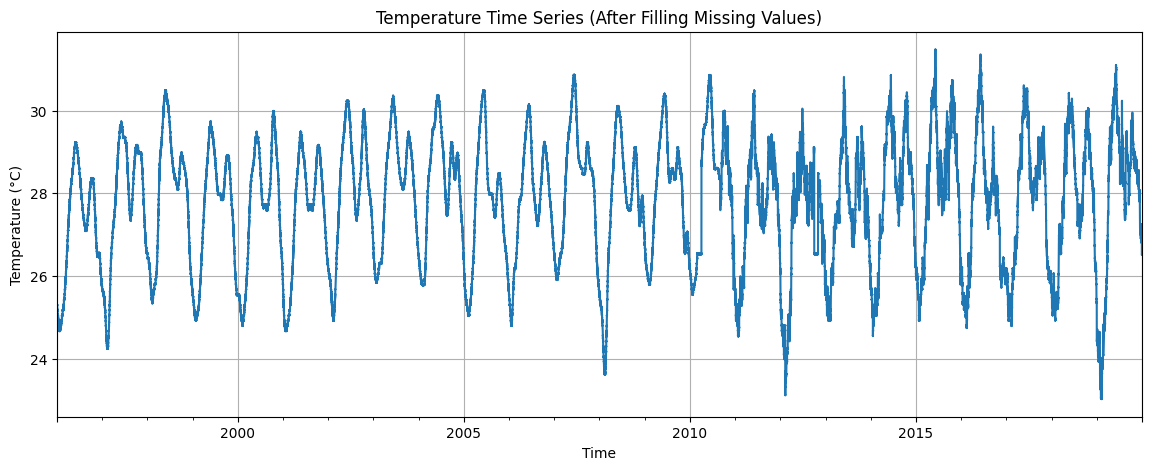

In [ ]:
# --- Step 4: Check and visualize missing values ---
# Calculates the number of missing values in the 'Temperature' column.
missing_count = df_temp['Temperature'].isna().sum()
# Prints the count and percentage of missing values.
print(f"Missing values: {missing_count} ({(missing_count / len(df_temp)) * 100:.2f}%)")

# Creates a matplotlib figure for the heatmap.
plt.figure(figsize=(14, 5))
# Generates a heatmap to visualize missing values across the DataFrame (transposed for better view).
sns.heatmap(df_temp.isna().T, cbar=True, cmap='viridis')
plt.title("Missing Value Visualization") # Sets the title of the heatmap.
plt.show() # Displays the heatmap.

# --- Step 5: Fill missing values (Linear Interpolation) ---
# Creates a copy of the original 'Temperature' values before interpolation.
original_temps = df_temp['Temperature'].copy()
# Fills missing values in 'Temperature' using linear interpolation.
df_temp['Temperature'] = df_temp['Temperature'].interpolate(method='linear')

# Optional: Forward fill any remaining NaNs (e.g., at the very beginning).
df_temp['Temperature'] = df_temp['Temperature'].ffill()
print() # Prints an empty line for spacing.

# --- Step 6: Visualize filled data ---
# Creates a matplotlib figure for the time series plot.
plt.figure(figsize=(14, 5))
# Plots the 'Temperature' time series after filling missing values.
df_temp['Temperature'].plot(title="Temperature Time Series (After Filling Missing Values)")
plt.xlabel("Time") # Sets the label for the x-axis.
plt.ylabel("Temperature (°C)") # Sets the label for the y-axis.
plt.grid(True) # Adds a grid to the plot.
plt.show() # Displays the time series plot.

## Time series decomposition

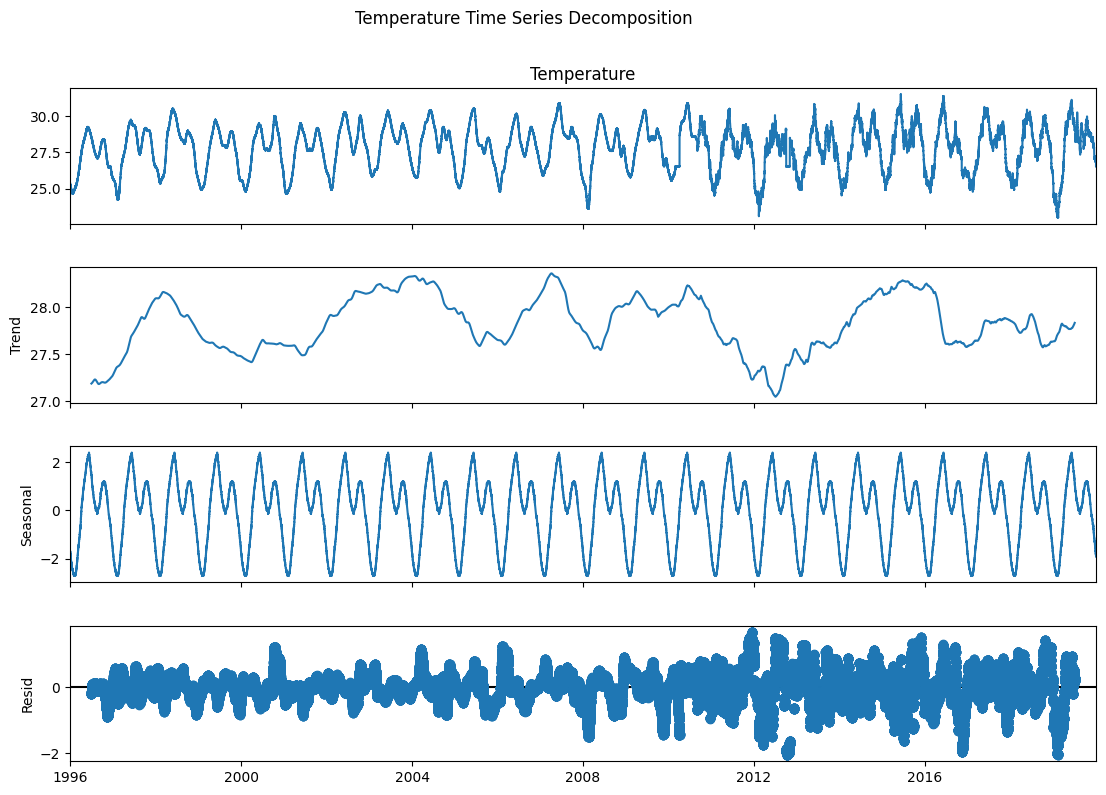

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose # Imports the function for time series decomposition.

decomposition = seasonal_decompose(df_temp['Temperature'], model='additive', period=8760) # Performs the decomposition on the 'Temperature' column. 'additive' model assumes components add up, 'period' is the number of data points in a cycle (yearly for hourly data).

# Plot the decomposed components.
fig = decomposition.plot() # Generates the plots for the observed, trend, seasonal, and residual components.
fig.set_size_inches(12, 8) # Sets the size of the figure for better visualization.
plt.suptitle('Temperature Time Series Decomposition', y=1.02) # Adds a main title to the entire figure.
plt.show() # Displays the plot.

# **Plot the ACF and PACF**

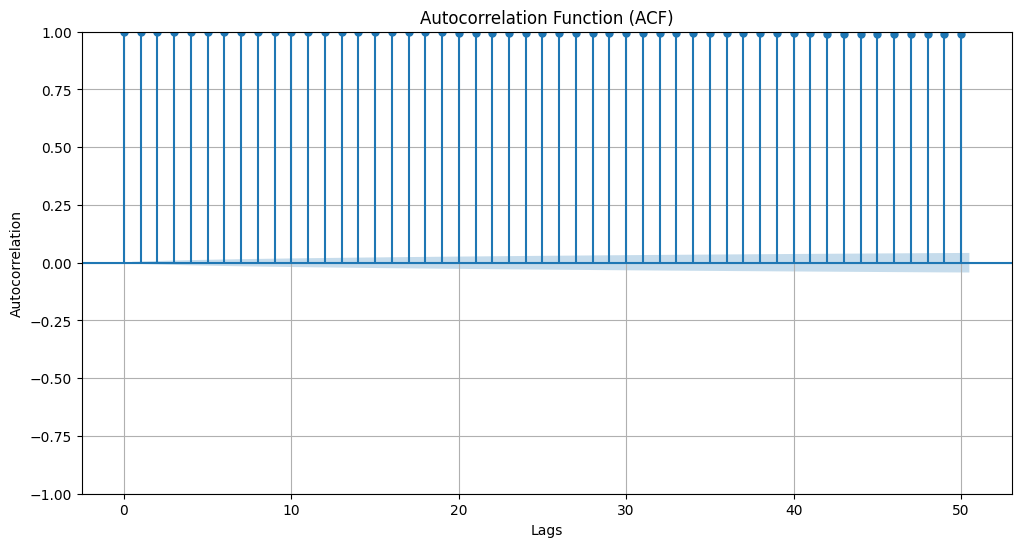

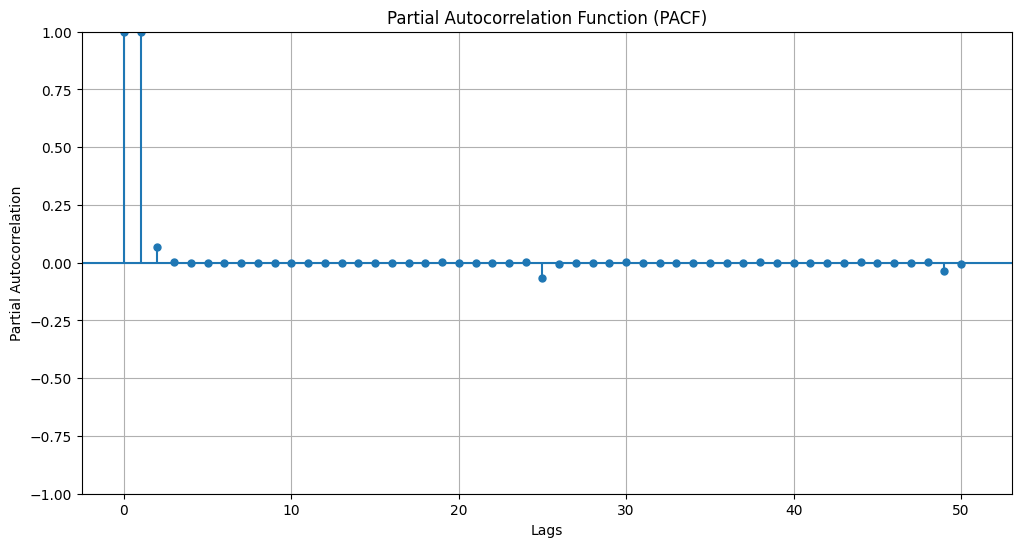

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Imports functions to plot ACF and PACF.

# Plot the Autocorrelation Function (ACF) to understand the correlation of the series with its lagged values.
plt.figure(figsize=(12, 6)) # Creates a new figure for the plot.
plot_acf(df_temp['Temperature'].dropna(), lags=50, ax=plt.gca()) # Generates the ACF plot. .dropna() handles potential NaNs. lags sets the max lag. ax specifies the plot area.
plt.title('Autocorrelation Function (ACF)') # Sets the title of the ACF plot.
plt.xlabel('Lags') # Sets the label for the x-axis.
plt.ylabel('Autocorrelation') # Sets the label for the y-axis.
plt.grid(True) # Adds a grid to the plot.
plt.show() # Displays the plot.

# Plot the Partial Autocorrelation Function (PACF) to understand the direct correlation with lagged values.
plt.figure(figsize=(12, 6)) # Creates a new figure for the plot.
plot_pacf(df_temp['Temperature'].dropna(), lags=50, ax=plt.gca()) # Generates the PACF plot.
plt.title('Partial Autocorrelation Function (PACF)') # Sets the title of the PACF plot.
plt.xlabel('Lags') # Sets the label for the x-axis.
plt.ylabel('Partial Autocorrelation') # Sets the label for the y-axis.
plt.grid(True) # Adds a grid to the plot.
plt.show() # Displays the plot.

## **Augmented Dickey-Fuller test**

In [ ]:
from statsmodels.tsa.stattools import adfuller # Imports the adfuller function for the ADF test.

print("Performing Augmented Dickey-Fuller Test:") # Prints a message indicating the test is starting.
adf_test = adfuller(df_temp['Temperature']) # Performs the ADF test on the 'Temperature' column.
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) # Creates a pandas Series to store the main test results.
for key,value in adf_test[4].items(): # Loops through the critical values dictionary.
    adf_output['Critical Value (%s)'%key] = value # Adds critical values to the output Series.
print(adf_output) # Prints the full ADF test results.

# Interpretation of the test result.
if adf_output['p-value'] <= 0.05: # Checks if the p-value is less than or equal to 0.05.
    print("Result: The time series is likely stationary (reject H0).") # Prints conclusion if stationary.
else: # If p-value is greater than 0.05.
    print("Result: The time series is likely non-stationary (fail to reject H0).") # Prints conclusion if non-stationary.
    print("Consider differencing the data if necessary.") # Suggests differencing for non-stationary data.

Performing Augmented Dickey-Fuller Test:
Test Statistic                     -5.065969
p-value                             0.000016
#Lags Used                         73.000000
Number of Observations Used    210310.000000
Critical Value (1%)                -3.430381
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566777
dtype: float64
Result: The time series is likely stationary (reject H0).


## Feature engineering

In [ ]:
# Create lagged features for temperature.
# These features can provide the model with information about past temperature values.
lag_features = [24,48,72] # Example lags (adjust based on your data and insights from ACF/PACF)
for lag in lag_features:
    df_temp[f'Temperature_lag_{lag}'] = df_temp['Temperature'].shift(lag) # Shifts the temperature data by 'lag' periods to create lagged features.

# Create rolling window statistics (e.g., rolling mean).
# Rolling statistics can capture local trends and variability.
rolling_window = 24 # Example window size (adjust based on seasonality or patterns)
df_temp['Temperature_rolling_mean'] = df_temp['Temperature'].rolling(window=rolling_window).mean() # Calculates the rolling mean over the specified window.
df_temp['Temperature_rolling_std'] = df_temp['Temperature'].rolling(window=rolling_window).std() # Calculates the rolling standard deviation over the specified window.

# Create time-based features from the index.
# These features help capture cyclical patterns (daily, weekly, yearly).
df_temp['hour'] = df_temp.index.hour # Extracts the hour of the day from the timestamp.
df_temp['dayofweek'] = df_temp.index.dayofweek # Extracts the day of the week from the timestamp.
df_temp['dayofyear'] = df_temp.index.dayofyear # Extracts the day of the year from the timestamp.
df_temp['month'] = df_temp.index.month # Extracts the month from the timestamp.
df_temp['year'] = df_temp.index.year # Extracts the year from the timestamp.

# Drop rows with NaN values created by lagging and rolling features.
df_temp.dropna(inplace=True) # Removes rows containing any NaN values.

# Display the first few rows of the DataFrame with new features
display(df_temp.head()) # Displays the head of the DataFrame to show the new features.

,Temperature,Temperature_lag_24,Temperature_lag_48,Temperature_lag_72,Temperature_rolling_mean,Temperature_rolling_std,hour,dayofweek,dayofyear,month,year
Time,,,,,,,,,,,
1996-01-04 00:00:00,25.300500,25.297510,25.288568,25.410059,25.292355,0.008623,0,3,4,1,1996
1996-01-04 01:00:00,25.303125,25.290857,25.298761,25.424219,25.292866,0.008890,1,3,4,1,1996
1996-01-04 02:00:00,25.274377,25.306970,25.317010,25.421625,25.291508,0.009128,2,3,4,1,1996
1996-01-04 03:00:00,25.293604,25.283167,25.317133,25.404688,25.291943,0.008960,3,3,4,1,1996
1996-01-04 04:00:00,25.281885,25.288293,25.305811,25.407556,25.291676,0.009167,4,3,4,1,1996


## Data normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# Define the list of features to be used for normalization.
# This includes the 'Temperature' column and all the engineered features.
features_temp = ['Temperature'] + [f'Temperature_lag_{lag}' for lag in [24, 48, 72]] + \
                ['Temperature_rolling_mean', 'Temperature_rolling_std', 'hour', 'dayofweek', 'dayofyear', 'month', 'year']

# Instantiate a MinMaxScaler object.
scaler_temp = MinMaxScaler()

# Apply the MinMaxScaler to the selected features in the DataFrame df.
# Store the scaled data in a new DataFrame.
df_scaled_temp = scaler_temp.fit_transform(df_temp[features_temp])
df_scaled_temp = pd.DataFrame(df_scaled_temp, columns=features_temp, index=df_temp.index)

# Define the path to save the scaler.
scaler_temp_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model"
os.makedirs(scaler_temp_path, exist_ok=True)

# Save the fitted MinMaxScaler object to a file using pickle.
scaler_temp_file = os.path.join(scaler_temp_path, 'scaler_temp_features.pkl')
with open(scaler_temp_file, 'wb') as f:
    pickle.dump(scaler_temp, f)

print(f"✅ Temperature data and features normalized. Scaler saved at: {scaler_temp_file}")

# Display the first few rows of the scaled DataFrame to verify.
display(df_scaled_temp.head())

✅ Temperature data and features normalized. Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model/scaler_temp_features.pkl


,Temperature,Temperature_lag_24,Temperature_lag_48,Temperature_lag_72,Temperature_rolling_mean,Temperature_rolling_std,hour,dayofweek,dayofyear,month,year
Time,,,,,,,,,,,
1996-01-04 00:00:00,0.269798,0.269445,0.268389,0.282728,0.267902,0.004496,0.000000,0.5,0.008219,0.0,0.0
1996-01-04 01:00:00,0.270107,0.268659,0.269592,0.284400,0.267963,0.004700,0.043478,0.5,0.008219,0.0,0.0
1996-01-04 02:00:00,0.266714,0.270561,0.271746,0.284093,0.267802,0.004883,0.086957,0.5,0.008219,0.0,0.0
1996-01-04 03:00:00,0.268984,0.267752,0.271761,0.282094,0.267854,0.004754,0.130435,0.5,0.008219,0.0,0.0
1996-01-04 04:00:00,0.267601,0.268357,0.270424,0.282433,0.267822,0.004913,0.173913,0.5,0.008219,0.0,0.0


## **False Nearest Neighbour(FNN)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from statsmodels.tsa.stattools import acf

def create_embedding(series, dim, tau):
    N = len(series)
    if N - (dim - 1) * tau <= 0:
        return np.empty((0, dim))
    embedded = np.empty((N - (dim - 1) * tau, dim))
    for i in range(dim):
        embedded[:, i] = series[i * tau : N - (dim - 1 - i) * tau]
    return embedded

def false_nearest_neighbors(series, max_dim=10, tau=1, R_tol=15.0, A_tol=2.0):
    N = len(series)
    raw_fnn_counts = []

    for dim in range(1, max_dim + 1):
        embedded = create_embedding(series, dim, tau)
        embedded_next = create_embedding(series, dim + 1, tau)

        if len(embedded_next) == 0:
            print(f"Dimension {dim}: Not enough data to compute embedding.")
            raw_fnn_counts.append(np.nan)
            continue

        total_points = len(embedded_next)
        false_neighbors = 0

        for i in range(total_points):
            point = embedded[i]
            dists = norm(embedded - point, axis=1)

            dists[i] = np.inf  # exclude self
            # exclude those that can't be mapped to dim+1 embedding
            valid_indices = np.arange(len(embedded_next))
            dists[~np.isin(np.arange(len(embedded)), valid_indices)] = np.inf

            if np.all(np.isinf(dists)):
                false_neighbors += 1
                continue

            nearest_index = np.argmin(dists)
            nearest_dist = dists[nearest_index]
            dist_m1 = abs(embedded_next[i, -1] - embedded_next[nearest_index, -1])

            R = dist_m1 / nearest_dist if nearest_dist != 0 else np.inf
            A = dist_m1

            if R > R_tol or A > A_tol:
                false_neighbors += 1

        raw_fnn_counts.append(false_neighbors)
        print(f"Dimension {dim}: Raw FNN count = {false_neighbors} / {total_points}")

    # Normalize FNN % with respect to dimension 1
    fnn_percentages = np.array(raw_fnn_counts, dtype=float)
    if not np.isnan(fnn_percentages[0]) and fnn_percentages[0] != 0:
        fnn_percentages = (fnn_percentages / fnn_percentages[0]) * 100
    else:
        fnn_percentages[:] = np.nan  # can't normalize

    for i, val in enumerate(fnn_percentages, start=1):
        print(f"Dimension {i}: FNN = {val:.2f}%")

    return fnn_percentages

No ACF < 1/e found. Using τ = 24.
Dimension 1: Raw FNN count = 18699 / 19976
Dimension 2: Raw FNN count = 5538 / 19952
Dimension 3: Raw FNN count = 1479 / 19928
Dimension 4: Raw FNN count = 905 / 19904
Dimension 5: Raw FNN count = 675 / 19880
Dimension 6: Raw FNN count = 626 / 19856
Dimension 7: Raw FNN count = 567 / 19832
Dimension 8: Raw FNN count = 527 / 19808
Dimension 9: Raw FNN count = 488 / 19784
Dimension 10: Raw FNN count = 448 / 19760
Dimension 1: FNN = 100.00%
Dimension 2: FNN = 29.62%
Dimension 3: FNN = 7.91%
Dimension 4: FNN = 4.84%
Dimension 5: FNN = 3.61%
Dimension 6: FNN = 3.35%
Dimension 7: FNN = 3.03%
Dimension 8: FNN = 2.82%
Dimension 9: FNN = 2.61%
Dimension 10: FNN = 2.40%


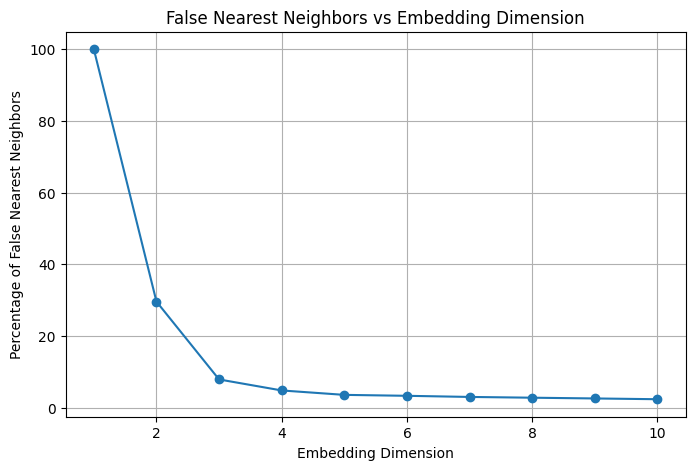

In [ ]:
# Step 1: Extract scaled temperature series (last ~2.3 years)
temperature_series_scaled = df_scaled_temp['Temperature'].values
short_series = temperature_series_scaled[-20000:]

# Step 2: Choose delay using ACF
autocorr = acf(short_series, nlags=100)
try:
    tau = next(i for i, val in enumerate(autocorr) if val < 1/np.e)
    print("Chosen delay τ:", tau)
except StopIteration:
    tau = 24
    print("No ACF < 1/e found. Using τ = 24.")

# Step 3: Run FNN algorithm
fnn_results = false_nearest_neighbors(short_series, max_dim=10, tau=tau)

# Step 4: Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), fnn_results, marker='o', linestyle='-')
plt.title("False Nearest Neighbors vs Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Percentage of False Nearest Neighbors")
plt.grid(True)
plt.show()

Chosen delay τ: 1
Dimension 1: Raw FNN count = 17804 / 19999
Dimension 2: Raw FNN count = 5978 / 19998
Dimension 3: Raw FNN count = 1935 / 19997
Dimension 4: Raw FNN count = 1213 / 19996
Dimension 5: Raw FNN count = 856 / 19995
Dimension 6: Raw FNN count = 543 / 19994
Dimension 7: Raw FNN count = 337 / 19993
Dimension 8: Raw FNN count = 270 / 19992
Dimension 9: Raw FNN count = 222 / 19991
Dimension 10: Raw FNN count = 190 / 19990
Dimension 1: FNN = 100.00%
Dimension 2: FNN = 33.58%
Dimension 3: FNN = 10.87%
Dimension 4: FNN = 6.81%
Dimension 5: FNN = 4.81%
Dimension 6: FNN = 3.05%
Dimension 7: FNN = 1.89%
Dimension 8: FNN = 1.52%
Dimension 9: FNN = 1.25%
Dimension 10: FNN = 1.07%


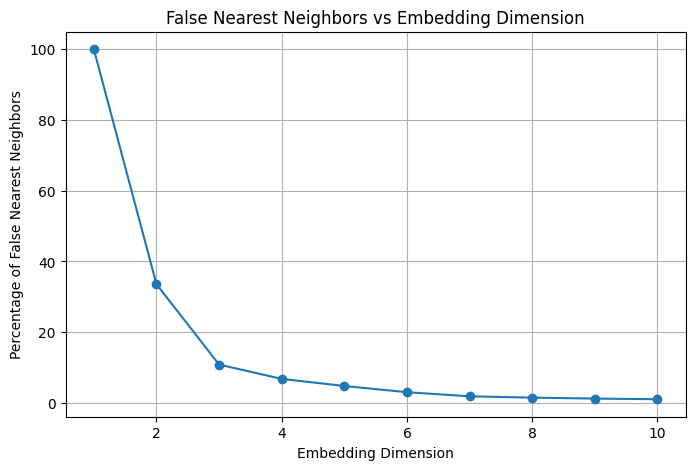

In [ ]:
# Step 1: Extract scaled temperature series (last ~2.3 years)
temperature_series_scaled = df_scaled_temp['Temperature'].values
short_series = temperature_series_scaled[-20000:]

# Step 2: Choose delay using ACF
tau = 1
print("Chosen delay τ:", tau)

# Step 3: Run FNN algorithm
fnn_results = false_nearest_neighbors(short_series, max_dim=10, tau=tau)

# Step 4: Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), fnn_results, marker='o', linestyle='-')
plt.title("False Nearest Neighbors vs Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Percentage of False Nearest Neighbors")
plt.grid(True)
plt.show()

## Prepare data for lstm

In [ ]:
import numpy as np # Imports the NumPy library for numerical operations and array manipulation.

# Define a function to create sequences for single-step prediction with multiple features.
def to_sequences_multi_feature_temp(data, seq_len=24):
    x, y = [], [] # Initializes empty lists to store input sequences (x) and output values (y).
    # Assuming 'Temperature' (the target) is the first column in the scaled data
    target_column_index = 0 # Defines the index of the target column ('Temperature').
    for i in range(len(data) - seq_len): # Loops through the data to create sequences.
        x.append(data[i : i + seq_len])  # Slices the data to create an input sequence of length seq_len and appends it to x.
        y.append(data[i + seq_len, target_column_index])  # Appends the target value (from the target column) at the time step after the sequence to y.
    return np.array(x), np.array(y) # Converts the lists x and y to NumPy arrays and returns them.

# Generate single-step sequences for the scaled temperature data.
sequence_length_temp = 24  # Use 24 hours to predict next hour # Defines the input sequence length.
temperature_array = df_scaled_temp.values # Get numpy array from scaled dataframe # Extracts the NumPy array of values from the scaled DataFrame.
X_single_temp, y_single_temp = to_sequences_multi_feature_temp(
    temperature_array, sequence_length_temp
) # Calls the function to generate single-step sequences.

# Reshape for LSTM: (samples, timesteps, features)
X_single_temp = X_single_temp.reshape(
    (X_single_temp.shape[0], X_single_temp.shape[1], X_single_temp.shape[2])
) # Reshapes the input sequences to the 3D format required by LSTM layers: [samples, timesteps, features].


# Define a function to create multi-step sequences for multi-feature LSTM.
def to_multi_sequences_temp(data, inp=24, out=24):
    X, y = [], [] # Initializes empty lists for input sequences (X) and output sequences (y).
    # Assuming 'Temperature' (the target) is the first column in the scaled data
    target_column_index = 0 # Defines the index of the target column.
    for i in range(len(data) - inp - out + 1): # Loops through the data to create multi-step sequences.
        X.append(data[i : i + inp])  # Slices the data to create an input sequence of length inp and appends it to X.
        y.append(
            data[i + inp : i + inp + out, target_column_index]
        )  # Slices the target column to create an output sequence of length out and appends it to y.
    return np.array(X), np.array(y) # Converts the lists X and y to NumPy arrays and returns them.

# Generate multi-step sequences for the scaled temperature data.
inp_length_temp = 24  # Input sequence length # Defines the input sequence length for the multi-step model.
out_length_temp = 24  # Output sequence length # Defines the output sequence length for the multi-step model.
X_multi_temp, y_multi_temp = to_multi_sequences_temp(
    df_scaled_temp.values, inp=inp_length_temp, out=out_length_temp
) # Calls the function to generate multi-step sequences.

# Reshape the multi-step input data for the LSTM layer (samples, time steps, features).
X_multi_temp = X_multi_temp.reshape(
    (X_multi_temp.shape[0], X_multi_temp.shape[1], X_multi_temp.shape[2])
) # Reshapes the multi-step input sequences to the 3D LSTM format.

# Print the shapes of the generated sequences
print(f"Shape of single-step X_single_temp: {X_single_temp.shape}") # Prints the shape of the single-step input array.
print(f"Shape of single-step y_single_temp: {y_single_temp.shape}") # Prints the shape of the single-step output array.
print(f"Shape of multi-step X_multi_temp: {X_multi_temp.shape}") # Prints the shape of the multi-step input array.
print(f"Shape of multi-step y_multi_temp: {y_multi_temp.shape}") # Prints the shape of the multi-step output array.

Shape of single-step X_single_temp: (210288, 24, 11)
Shape of single-step y_single_temp: (210288,)
Shape of multi-step X_multi_temp: (210265, 24, 11)
Shape of multi-step y_multi_temp: (210265, 24)


## Split data

In [ ]:
# Determine the split index for single-step data (80% for training)
split_index_single_temp = int(0.8 * len(X_single_temp)) # Calculate the index for an 80/20 split based on the number of single-step sequences.

# Split the single-step data
X_train_single_temp, X_val_single_temp = X_single_temp[:split_index_single_temp], X_single_temp[split_index_single_temp:] # Split the single-step input data (X) into training and validation sets based on the calculated index.
y_train_single_temp, y_val_single_temp = y_single_temp[:split_index_single_temp], y_single_temp[split_index_single_temp:] # Split the single-step target data (y) into training and validation sets using the same index.

# Determine the split index for multi-step data (using the same proportion)
split_index_multi_temp = int(0.8 * len(X_multi_temp)) # Calculate the index for an 80/20 split based on the number of multi-step sequences.

# Split the multi-step data
X_train_multi_temp, X_val_multi_temp = X_multi_temp[:split_index_multi_temp], X_multi_temp[split_index_multi_temp:] # Split the multi-step input data (X) into training and validation sets.
y_train_multi_temp, y_val_multi_temp = y_multi_temp[:split_index_multi_temp], y_multi_temp[split_index_multi_temp:] # Split the multi-step target data (y) into training and validation sets.

# Print the shapes of the resulting training and validation sets
print("Single-step data shapes:") # Print a header for single-step data shapes.
print(f"X_train_single_temp shape: {X_train_single_temp.shape}") # Print the shape of the single-step training input data.
print(f"X_val_single_temp shape: {X_val_single_temp.shape}") # Print the shape of the single-step validation input data.
print(f"y_train_single_temp shape: {y_train_single_temp.shape}") # Print the shape of the single-step training target data.
print(f"y_val_single_temp shape: {y_val_single_temp.shape}") # Print the shape of the single-step validation target data.
print("\nMulti-step data shapes:") # Print a header for multi-step data shapes.
print(f"X_train_multi_temp shape: {X_train_multi_temp.shape}") # Print the shape of the multi-step training input data.
print(f"X_val_multi_temp shape: {X_val_multi_temp.shape}") # Print the shape of the multi-step validation input data.
print(f"y_train_multi_temp shape: {y_train_multi_temp.shape}") # Print the shape of the multi-step training target data.
print(f"y_val_multi_temp shape: {y_val_multi_temp.shape}") # Print the shape of the multi-step validation target data.

Single-step data shapes:
X_train_single_temp shape: (168230, 24, 11)
X_val_single_temp shape: (42058, 24, 11)
y_train_single_temp shape: (168230,)
y_val_single_temp shape: (42058,)

Multi-step data shapes:
X_train_multi_temp shape: (168212, 24, 11)
X_val_multi_temp shape: (42053, 24, 11)
y_train_multi_temp shape: (168212, 24)
y_val_multi_temp shape: (42053, 24)


## Implement vanilla lstm model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the input shape for the single-step model
# X_train_single_temp has shape (samples, timesteps, features)
input_shape_temp = (X_train_single_temp.shape[1], X_train_single_temp.shape[2]) # (timesteps, features)

# Build the Vanilla LSTM model
model_vanilla_temp = Sequential([
    # Single LSTM layer
    LSTM(50, input_shape=input_shape_temp), # 50 units, input shape is (timesteps, features)

    # Output layer for single-step prediction
    Dense(1, activation='linear') # 1 unit for the next single temperature value
])

# Compile the model
model_vanilla_temp.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
model_vanilla_temp.summary()

## Train vanilla lstm model

In [ ]:
# Compile the model
model_vanilla_temp.compile(optimizer='adam', loss='mse')

# Train the model
history_vanilla_single = model_vanilla_temp.fit(X_train_single_temp, y_train_single_temp,
                                           epochs=10,
                                           batch_size=64,
                                           validation_data=(X_val_single_temp, y_val_single_temp))

# Plot the training and validation loss over epochs.
plt.figure(figsize=(10, 6))
plt.plot(history_vanilla_single.history['loss'], label='Train Loss')
plt.plot(history_vanilla_single.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Vanilla Single-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

## Save Vanilla LSTM Model and Scaler

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the Vanilla LSTM model and scaler.
vanilla_temp_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model"
os.makedirs(vanilla_temp_model_path, exist_ok=True)

# Save the trained Vanilla LSTM model in .h5 format.
model_vanilla_temp_file = os.path.join(vanilla_temp_model_path, 'vanilla_fnn24.h5')
save_model(model_vanilla_temp, model_vanilla_temp_file)

# Save the fitted MinMaxScaler (assuming scaler_temp is the one used for normalization).
scaler_vanilla_temp_file = os.path.join(vanilla_temp_model_path, 'scaler_vanilla_fnn24_features.pkl')
with open(scaler_vanilla_temp_file, 'wb') as f:
    pickle.dump(scaler_temp, f) # Use scaler_temp that was fitted earlier

print("✅ Vanilla LSTM Temperature Model and Scaler saved successfully.")
print(f"Model saved at: {model_vanilla_temp_file}")
print(f"Scaler saved at: {scaler_vanilla_temp_file}")

## Implement Stacked LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the input shape based on your training data X_train_single_temp
n_steps = X_train_single_temp.shape[1] # Number of time steps in each sequence
n_features = X_train_single_temp.shape[2] # Number of features at each time step

# Define the simple stacked LSTM model
model_simple_stacked_temp = Sequential()
model_simple_stacked_temp.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features))) # First LSTM layer, returns sequences for stacking
model_simple_stacked_temp.add(LSTM(50, activation='relu')) # Second LSTM layer, outputs a single vector
model_simple_stacked_temp.add(Dense(1, activation='linear')) # Output layer for single-step prediction (using linear for temperature)

# Compile the model (using the same optimizer and loss as before for comparison)
model_simple_stacked_temp.compile(optimizer='adam', loss='mse')

# Print the model summary
model_simple_stacked_temp.summary()

## Train Stacked LSTM Model

In [ ]:
# The model was already compiled in the previous step, but compiling again doesn't hurt if parameters are the same.
# model_simple_stacked_temp.compile(optimizer='adam', loss='mse')

# Train the model
history_stacked_single = model_simple_stacked_temp.fit(X_train_single_temp, y_train_single_temp,
                                                        epochs=10, # Use the same number of epochs as previous models for consistency
                                                        batch_size=64, # Use a typical batch size
                                                        validation_data=(X_val_single_temp, y_val_single_temp)) # Use validation data to monitor performance

import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_stacked_single.history['loss'], label='Train Loss')
plt.plot(history_stacked_single.history['val_loss'], label='Validation Loss')
plt.title('Stacked Single-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


## Save Stacked LSTM Model and Scaler

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the simple Stacked LSTM model and scaler.
simple_stacked_temp_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model"
os.makedirs(simple_stacked_temp_model_path, exist_ok=True)

# Save the trained simple Stacked LSTM model in .h5 format.
model_simple_stacked_temp_file = os.path.join(simple_stacked_temp_model_path, 'stacked_fnn24.h5')
save_model(model_simple_stacked_temp, model_simple_stacked_temp_file)

# Save the fitted MinMaxScaler (assuming scaler_temp is the one used for normalization).
scaler_simple_stacked_temp_file = os.path.join(simple_stacked_temp_model_path, 'scaler_stacked_fnn24_features.pkl')
with open(scaler_simple_stacked_temp_file, 'wb') as f:
    pickle.dump(scaler_temp, f) # Use scaler_temp that was fitted earlier

print("✅ Simple Stacked LSTM Temperature Model and Scaler saved successfully.")
print(f"Model saved at: {model_simple_stacked_temp_file}")
print(f"Scaler saved at: {scaler_simple_stacked_temp_file}")

## Implement bidirectional lstm model

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Define the input shape for the Bidirectional LSTM model
# Use the shape of the single-step training data, excluding the number of samples
input_shape_temp = (X_train_single_temp.shape[1], X_train_single_temp.shape[2])

# Build the Bidirectional LSTM model
model_bidirectional_temp = Sequential([
    # Bidirectional LSTM layer wrapping an LSTM layer
    Bidirectional(LSTM(50, return_sequences=False), # 50 LSTM units, return_sequences=False for single output per sequence
                  input_shape=input_shape_temp), # Define input shape

    # Output layer for single-step prediction
    Dense(1, activation='linear') # Single output neuron with linear activation for temperature
])

# Compile the model
model_bidirectional_temp.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
model_bidirectional_temp.summary() # Display the model's architecture and parameter count

## Train Bidirectional LSTM Model

In [ ]:
# Compile the model
model_bidirectional_temp.compile(optimizer='adam', loss='mse')

# Train the model
history_bidirectional_single = model_bidirectional_temp.fit(X_train_single_temp, y_train_single_temp,
                                                      epochs=10,
                                                      batch_size=64,
                                                      validation_data=(X_val_single_temp, y_val_single_temp))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_bidirectional_single.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_single.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional Single-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Save Bidirectional LSTM Model and Scaler

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the Bidirectional LSTM model and scaler.
bidirectional_temp_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model"
os.makedirs(bidirectional_temp_model_path, exist_ok=True)

# Save the trained Bidirectional LSTM model in .h5 format.
model_bidirectional_temp_file = os.path.join(bidirectional_temp_model_path, 'bidirectional_fnn24.h5')
save_model(model_bidirectional_temp, model_bidirectional_temp_file)

# Save the fitted MinMaxScaler (assuming scaler_temp is the one used for normalization).
scaler_bidirectional_temp_file = os.path.join(bidirectional_temp_model_path, 'scaler_bidirectional_fnn24_features.pkl')
with open(scaler_bidirectional_temp_file, 'wb') as f:
    pickle.dump(scaler_temp, f) # Use scaler_temp that was fitted earlier

print("✅ Bidirectional LSTM Temperature Model and Scaler saved successfully.")
print(f"Model saved at: {model_bidirectional_temp_file}")
print(f"Scaler saved at: {scaler_bidirectional_temp_file}")

## Evaluate and Compare Vanilla, Stacked, and Bidirectional LSTM Models

✅ 'features_temp' list updated to match df_scaled_temp columns: 11 features for inverse transformation.


✅ Vanilla Single-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model/vanilla_fnn24.h5


✅ Stacked Single-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model/stacked_fnn24.h5


✅ Bidirectional Single-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model/bidirectional_fnn24.h5
✅ Main scaler loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model/scaler_temp_features.pkl.
✅ True validation values inverse transformed for metric calculation.
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
✅ Predictions made for Vanilla LSTM.
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step
✅ Predictions made for Stacked LSTM.
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step
✅ Predictions made for Bidirectional LSTM.

Vanilla LSTM Evaluation:
  MAE: 0.0172°C
  RMSE: 0.0428°C
  R2: 0.9994

Stacked LSTM Evaluation:
  MAE: 0.0229°C
  RMSE: 0.0456°C
  R2: 0.9993

Bidirectional LSTM Evaluation:
  MAE: 0.0159°C
  RMSE: 0.0422°C
  R2: 0.9994


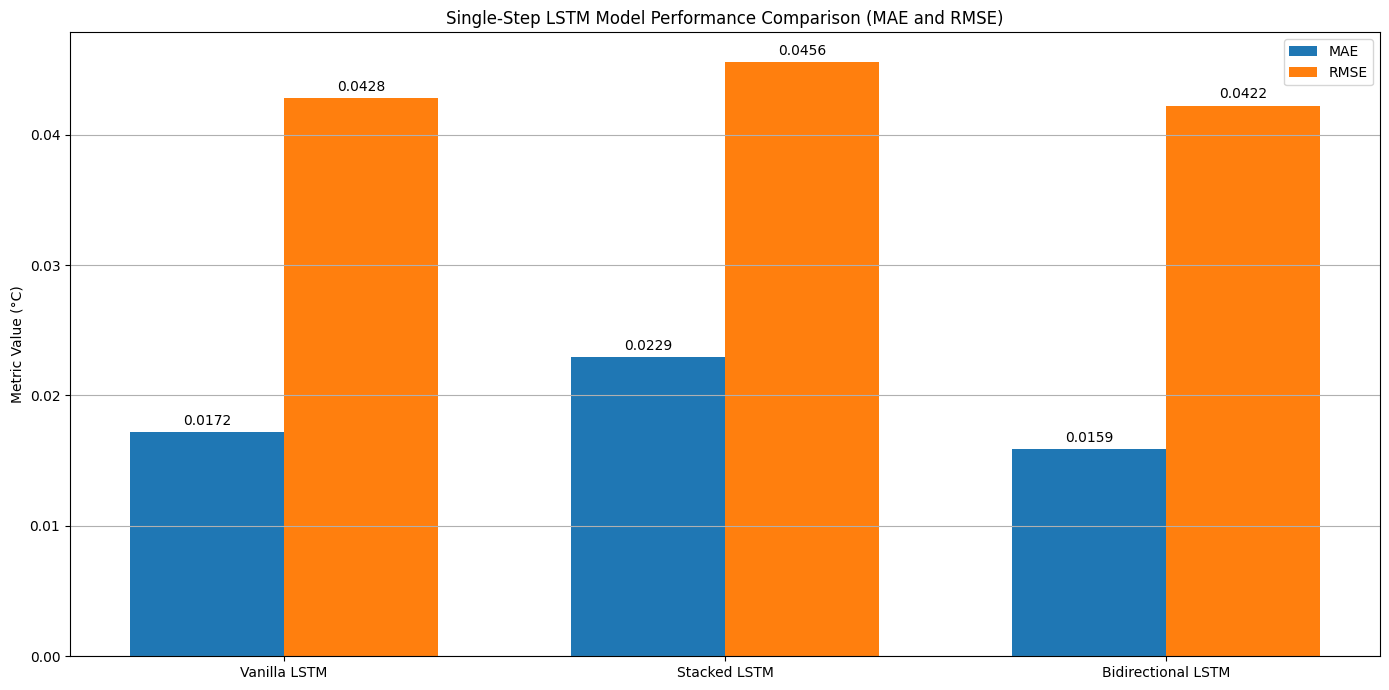

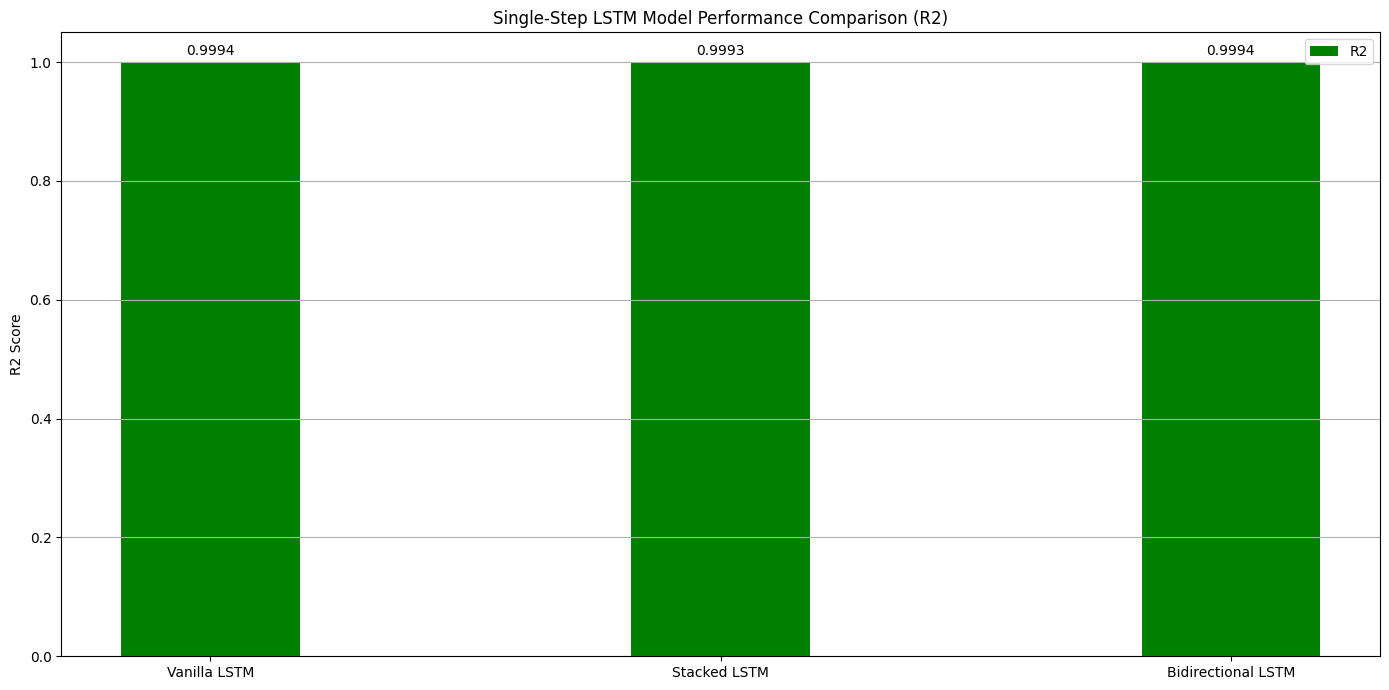


--- Sample Prediction Comparison (First 200 points - Bidirectional LSTM) ---


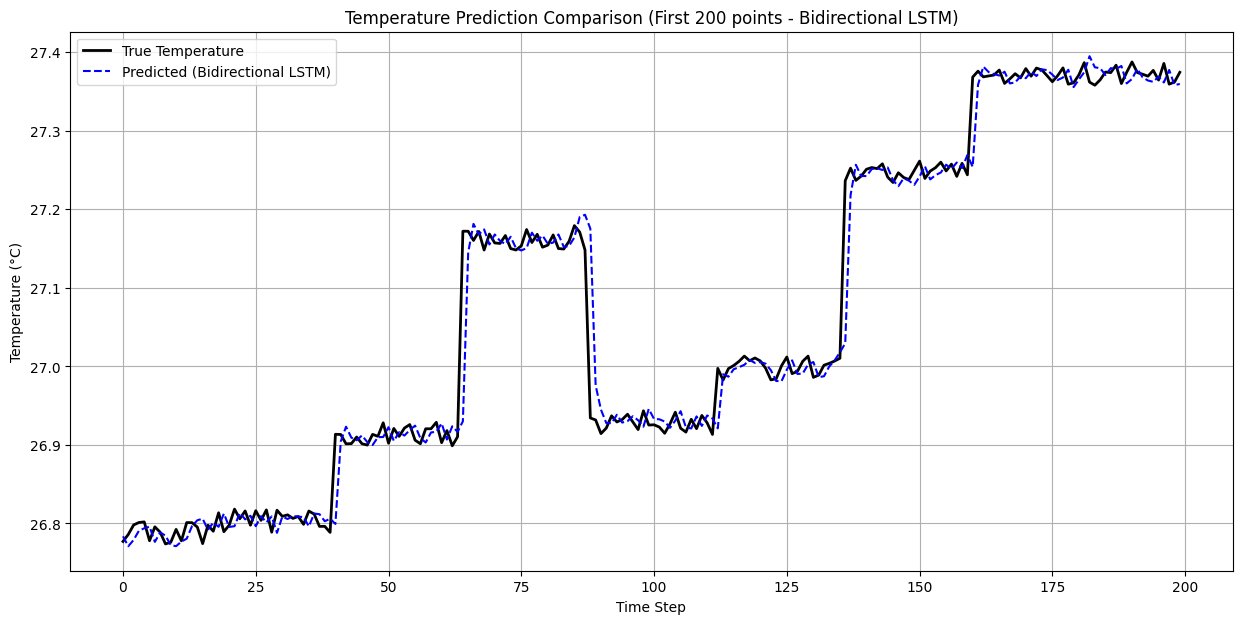


--- Complete Validation Set Predictions Comparison (Bidirectional LSTM) ---


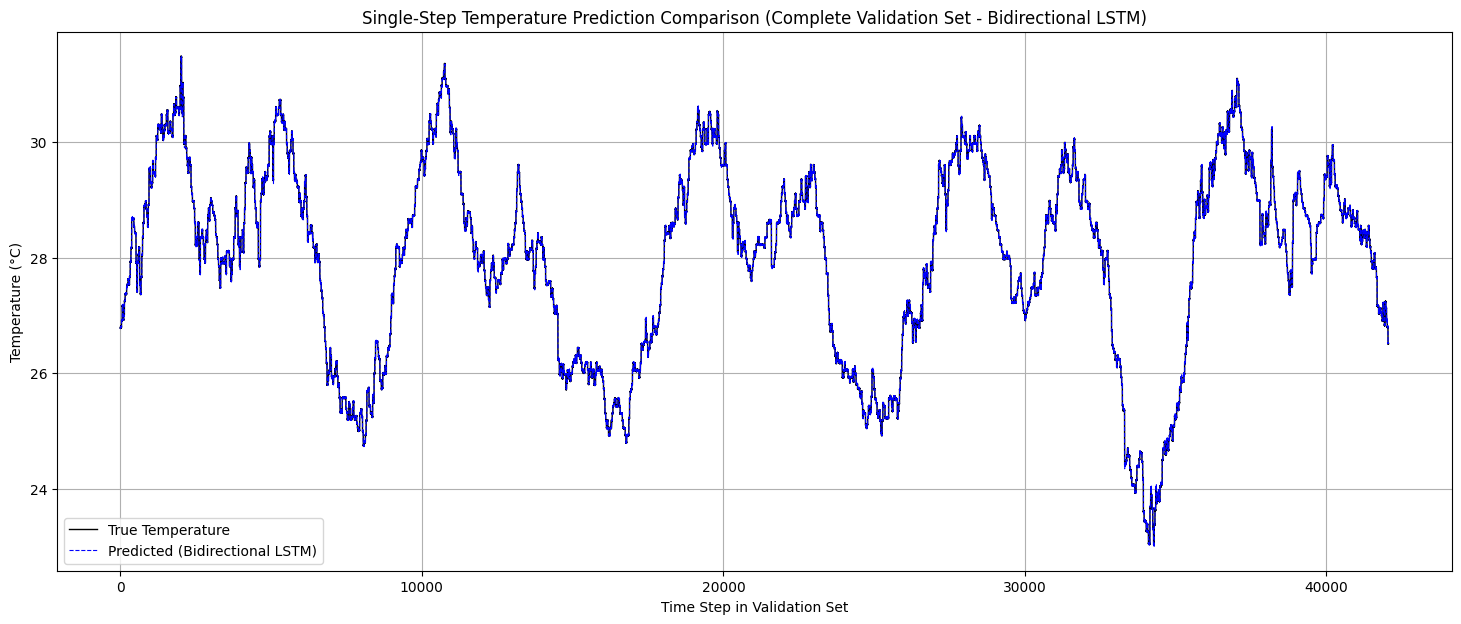


--- Scatter Plot: Predicted vs Observed (Single-Step Models) ---


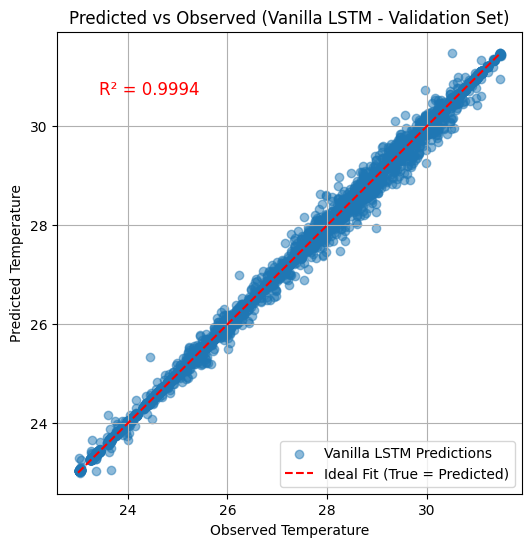

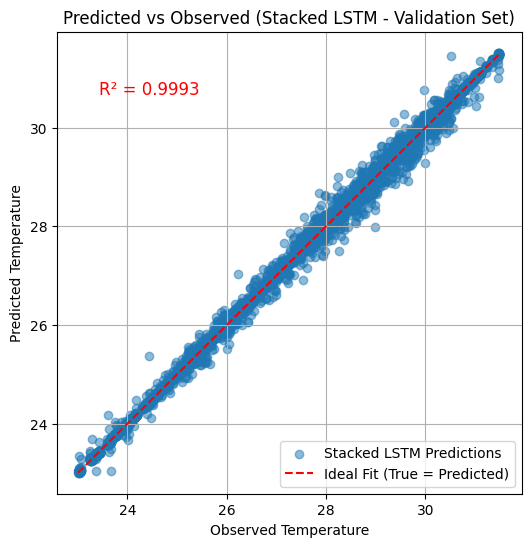

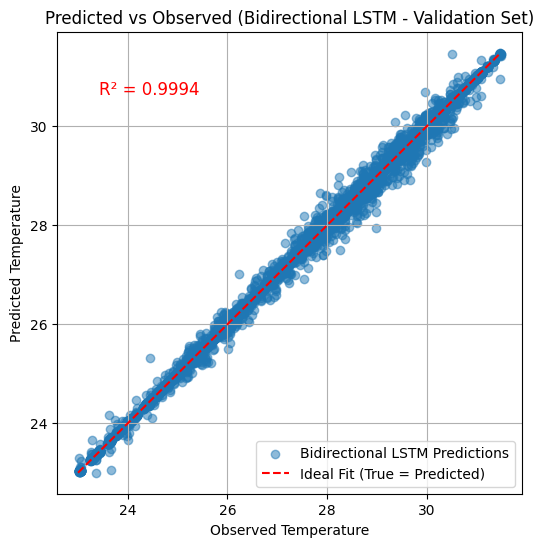


--- Making Future Forecast with the Selected Single-Step Model ---
Using the selected single-step model for forecasting: Bidirectional LSTM
Using sequence length from X_train_single_temp: 24
✅ Main scaler loaded successfully for single-step forecasting from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model/scaler_temp_features.pkl.
✅ Data prepared for future single-step forecasting. Input shape: (1, 24, 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Bidirectional LSTM Forecast for 2020-01-01 00:00:00: 26.5098°C

--- Plotting Future Forecast vs Original Data (Selected Single-Step Model) ---


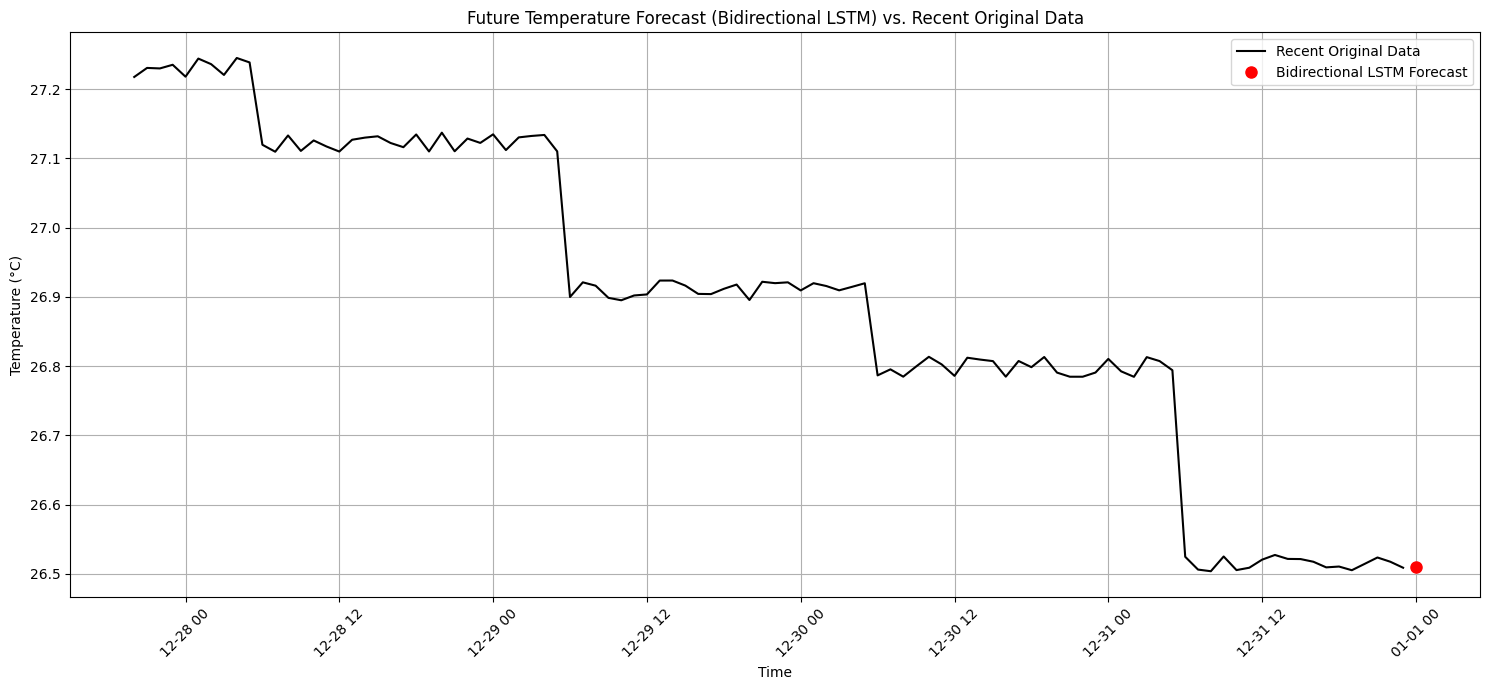

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pickle
import pandas as pd # Import pandas for DataFrame and Timedelta
import seaborn as sns

# Define the path to the single-step models and scalers
singlestep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/singlestep_model"

# Define the file paths for models
model_vanilla_file = os.path.join(singlestep_model_path, 'vanilla_fnn24.h5')
model_stacked_file = os.path.join(singlestep_model_path, 'stacked_fnn24.h5')
model_bidirectional_file = os.path.join(singlestep_model_path, 'bidirectional_fnn24.h5')

# Define the path to the main scaler file (fitted on all 11 features)
# Assuming the scaler fitted on the data with all engineered features (11 features based on earlier cells) was saved in a specific location.
main_scaler_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model" # Example path, adjust as needed
main_scaler_file = os.path.join(main_scaler_path, 'scaler_temp_features.pkl') # Assuming the main 11-feature scaler file name


features_temp = None
if 'df_scaled_temp' in locals() and df_scaled_temp is not None and not df_scaled_temp.empty:
     features_temp = list(df_scaled_temp.columns)
     print(f"✅ 'features_temp' list updated to match df_scaled_temp columns: {len(features_temp)} features for inverse transformation.")
else:
    # Default to 11 features if df_scaled_temp is not available or has unexpected columns
    features_temp = ['Temperature', 'Temperature_lag_24', 'Temperature_lag_48', 'Temperature_lag_72',
                     'Temperature_rolling_mean', 'Temperature_rolling_std', 'hour', 'dayofweek',
                     'dayofyear', 'month', 'year']
    print(f"✅ 'features_temp' list set to {len(features_temp)} features for inverse transformation (df_scaled_temp not available or columns unexpected).")


# --- Load Models ---

models_single_loaded = {} # Dictionary to store loaded single-step models

# Load Vanilla Single-Step Model
try:
    models_single_loaded['Vanilla LSTM'] = load_model(model_vanilla_file, custom_objects={'mse': MeanSquaredError()})
    print(f"✅ Vanilla Single-Step model loaded successfully from {model_vanilla_file}")
except Exception as e:
    print(f"Error loading Vanilla Single-Step model from {model_vanilla_file}: {e}. Skipping evaluation for this model.")

# Load Stacked Single-Step Model
try:
    models_single_loaded['Stacked LSTM'] = load_model(model_stacked_file, custom_objects={'mse': MeanSquaredError()})
    print(f"✅ Stacked Single-Step model loaded successfully from {model_stacked_file}")
except Exception as e:
    print(f"Error loading Stacked Single-Step model from {model_stacked_file}: {e}. Skipping evaluation for this model.")

# Load Bidirectional Single-Step Model
try:
    models_single_loaded['Bidirectional LSTM'] = load_model(model_bidirectional_file, custom_objects={'mse': MeanSquaredError()})
    print(f"✅ Bidirectional Single-Step model loaded successfully from {model_bidirectional_file}")
except Exception as e:
    print(f"Error loading Bidirectional Single-Step model from {model_bidirectional_file}: {e}. Skipping evaluation for this model.")


# Load the main scaler (fitted on 11 features)
scaler_loaded = None
try:
    with open(main_scaler_file, 'rb') as f:
        scaler_loaded = pickle.load(f)
    print(f"✅ Main scaler loaded successfully from {main_scaler_file}.")
except Exception as e:
    print(f"FATAL Error: Could not load the main scaler from {main_scaler_file}: {e}. Cannot proceed with evaluation.")
    raise SystemExit("Scaler loading failed.")


# Ensure validation data is available (assuming X_val_single_temp and y_val_single_temp are in memory)
if 'X_val_single_temp' not in locals() or 'y_val_single_temp' not in locals():
     print("FATAL Error: Validation data (X_val_single_temp, y_val_single_temp) not found in memory. Please run data preparation steps.")
     # Exit or handle this case appropriately
     raise SystemExit("Validation data not found.")

# Ensure at least one model was loaded
if not models_single_loaded:
     print("FATAL Error: No single-step models were loaded successfully. Cannot proceed with evaluation.")
     raise SystemExit("No single-step models loaded.")

# Ensure features_temp is correctly defined and matches the scaler's expected input shape
if features_temp is None or len(features_temp) != scaler_loaded.n_features_in_:
     print(f"FATAL Error: 'features_temp' list ({len(features_temp) if features_temp is not None else 'None'} features) does not match the loaded scaler's expected input features ({scaler_loaded.n_features_in_}). Please check feature engineering and scaling steps.")
     raise SystemExit("Feature mismatch with scaler.")


# --- Inverse Transform True Values (only need to do this once) ---
# y_val_single_temp contains scaled true values. Inverse transform them for metric calculation.
# Use the features_temp list with 11 features for the dummy array for inverse transformation
dummy_true_array_temp = np.zeros((y_val_single_temp.shape[0], len(features_temp)))
dummy_true_array_temp[:, 0] = y_val_single_temp.flatten()
y_true_single_temp_orig = scaler_loaded.inverse_transform(dummy_true_array_temp)[:, 0]
print("✅ True validation values inverse transformed for metric calculation.")


# --- Make Predictions and Collect Results for Comparison ---

predictions_orig = {} # Dictionary to store inverse transformed predictions for comparison

for model_name, model_loaded in models_single_loaded.items():
     try:
          y_pred_single_scaled = model_loaded.predict(X_val_single_temp)

          # Inverse transform the prediction using the scaler fitted on 11 features
          dummy_pred_array_temp = np.zeros((y_pred_single_scaled.shape[0], len(features_temp)))
          dummy_pred_array_temp[:, 0] = y_pred_single_scaled.flatten()
          predictions_orig[model_name] = scaler_loaded.inverse_transform(dummy_pred_array_temp)[:, 0]
          print(f"✅ Predictions made for {model_name}.")

     except Exception as e:
          print(f"Error making predictions with {model_name}: {e}. Skipping predictions for this model.")


# --- Calculate Metrics and Visualize Comparison if predictions are available ---

if predictions_orig: # Only proceed if at least one model successfully made predictions
    metrics = {} # Dictionary to store MAE, RMSE, and R2 for each model

    for model_name, y_pred_orig in predictions_orig.items():
        mae = mean_absolute_error(y_true_single_temp_orig, y_pred_orig)
        rmse = np.sqrt(mean_squared_error(y_true_single_temp_orig, y_pred_orig))
        r2 = r2_score(y_true_single_temp_orig, y_pred_orig)
        metrics[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"\n{model_name} Evaluation:")
        print(f"  MAE: {mae:.4f}°C")
        print(f"  RMSE: {rmse:.4f}°C")
        print(f"  R2: {r2:.4f}")


    # --- Visualize Overall Performance Comparison (Bar Plot) ---
    if metrics:
        model_names = list(metrics.keys())
        x = np.arange(len(model_names)) # the label locations
        width = 0.35

        # Plot MAE and RMSE
        fig_mae_rmse, ax_mae_rmse = plt.subplots(figsize=(14, 7))
        rects_mae = ax_mae_rmse.bar(x - width/2, [metrics[name]['MAE'] for name in model_names], width, label='MAE')
        rects_rmse = ax_mae_rmse.bar(x + width/2, [metrics[name]['RMSE'] for name in model_names], width, label='RMSE')

        ax_mae_rmse.set_ylabel('Metric Value (°C)')
        ax_mae_rmse.set_title('Single-Step LSTM Model Performance Comparison (MAE and RMSE)')
        ax_mae_rmse.set_xticks(x)
        ax_mae_rmse.set_xticklabels(model_names)
        ax_mae_rmse.legend()
        ax_mae_rmse.grid(True, axis='y')

        # Add value labels on top of bars
        def autolabel(rects, ax):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('%.4f' % height,
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3), # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects_mae, ax_mae_rmse)
        autolabel(rects_rmse, ax_mae_rmse)
        fig_mae_rmse.tight_layout()
        plt.show()

        # Plot R2
        fig_r2, ax_r2 = plt.subplots(figsize=(14, 7))
        rects_r2 = ax_r2.bar(x, [metrics[name]['R2'] for name in model_names], width, label='R2', color='green')

        ax_r2.set_ylabel('R2 Score')
        ax_r2.set_title('Single-Step LSTM Model Performance Comparison (R2)')
        ax_r2.set_xticks(x)
        ax_r2.set_xticklabels(model_names)
        ax_r2.legend()
        ax_r2.grid(True, axis='y')
        ax_r2.set_ylim(0, 1.05) # R2 is typically between 0 and 1

        autolabel(rects_r2, ax_r2)
        fig_r2.tight_layout()
        plt.show()


    else:
        print("\nSkipping comparison visualization as no metrics were available.")


    # --- Visualize Sample Predictions Comparison (First 200 points) for the Best Model ---
    selected_model_for_plots_single = "Bidirectional LSTM"
    if selected_model_for_plots_single in predictions_orig:
        print(f"\n--- Sample Prediction Comparison (First 200 points - {selected_model_for_plots_single}) ---")
        plt.figure(figsize=(15, 7))
        plt.plot(y_true_single_temp_orig[:200], label='True Temperature', color='black', linewidth=2) # Plot true values clearly

        y_pred_orig = predictions_orig[selected_model_for_plots_single]
        plt.plot(y_pred_orig[:200], label=f'Predicted ({selected_model_for_plots_single})', color='blue', linestyle='--')

        plt.title(f'Temperature Prediction Comparison (First 200 points - {selected_model_for_plots_single})')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"\nSkipping sample prediction comparison visualization for {selected_model_for_plots_single} as predictions are not available.")


    # --- Add Plot for Complete Validation Set Comparison for the Best Model ---
    if selected_model_for_plots_single in predictions_orig:
        print(f"\n--- Complete Validation Set Predictions Comparison ({selected_model_for_plots_single}) ---")
        plt.figure(figsize=(18, 7))

        # Plot true values for the complete validation set
        plt.plot(y_true_single_temp_orig, label='True Temperature', color='black', linewidth=1)

        y_pred_orig = predictions_orig[selected_model_for_plots_single]
        # Plot the predictions for the complete validation set
        plt.plot(y_pred_orig, label=f'Predicted ({selected_model_for_plots_single})', color='blue', linestyle='--', linewidth=0.8)

        plt.title(f'Single-Step Temperature Prediction Comparison (Complete Validation Set - {selected_model_for_plots_single})')
        plt.xlabel('Time Step in Validation Set')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"\nSkipping complete validation set prediction comparison visualization for {selected_model_for_plots_single} as predictions are not available.")

    # --- Add Scatter Plot: Predicted vs Observed (All Single-Step Models) ---
    if y_true_single_temp_orig is not None and predictions_orig:
        print("\n--- Scatter Plot: Predicted vs Observed (Single-Step Models) ---")
        for model_name, y_pred_orig in predictions_orig.items(): # This loop will run for all loaded models
            try:
                # Ensure y_true and y_pred have the same shape
                if y_true_single_temp_orig.shape == y_pred_orig.shape:
                    r2 = r2_score(y_true_single_temp_orig, y_pred_orig)

                    plt.figure(figsize=(6, 6))
                    plt.scatter(y_true_single_temp_orig, y_pred_orig, alpha=0.5, label=f'{model_name} Predictions') # Added label for scatter points
                    # Plotting the ideal fit line (y=x)
                    min_val = min(y_true_single_temp_orig.min(), y_pred_orig.min()) if y_true_single_temp_orig.size > 0 and y_pred_orig.size > 0 else 0
                    max_val = max(y_true_single_temp_orig.max(), y_pred_orig.max()) if y_true_single_temp_orig.size > 0 and y_pred_orig.size > 0 else 1
                    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (True = Predicted)') # Added label for ideal fit line

                    plt.xlabel("Observed Temperature")
                    plt.ylabel("Predicted Temperature")
                    plt.title(f"Predicted vs Observed ({model_name} - Validation Set)")
                    plt.legend() # Added legend call
                    # Position R2 annotation relative to plot limits
                    x_pos = min_val + (max_val - min_val) * 0.05 # 5% from left
                    y_pos = max_val - (max_val - min_val) * 0.1 # 10% from top
                    plt.annotate(f'R² = {r2:.4f}', xy=(x_pos, y_pos), fontsize=12, color='red')

                    plt.grid(True)
                    plt.show()
                else:
                    print(f"Skipping scatter plot for {model_name} due to shape mismatch.")

            except Exception as e:
                print(f"Error generating scatter plot for {model_name}: {e}")
    else:
        print("\nSkipping scatter plot for single-step models as true values or predictions are not available.")



else:
    print("\nSkipping metric calculation and prediction comparison visualizations as no predictions were made.")


# --- Make Future Forecast with the Selected Single-Step Model ---

print("\n--- Making Future Forecast with the Selected Single-Step Model ---")

# Specify the model name to use for the future forecast plot
selected_model_single_step_forecast = "Bidirectional LSTM" # Use Bidirectional for forecasting

if selected_model_single_step_forecast is not None and selected_model_single_step_forecast in models_single_loaded:
    selected_model_loaded = models_single_loaded[selected_model_single_step_forecast]
    print(f"Using the selected single-step model for forecasting: {selected_model_single_step_forecast}")

    # Assuming df_temp is your original DataFrame with engineered features, sorted by time.
    # You need the last 'seq_len' data points from the DataFrame with engineered features.
    # Check if X_train_single_temp exists to get the sequence length
    if 'X_train_single_temp' in locals() and X_train_single_temp is not None:
         seq_len = X_train_single_temp.shape[1] # Input sequence length for single-step models (should match training)
         print(f"Using sequence length from X_train_single_temp: {seq_len}")
    else:
         seq_len = 24 # Default to 24 if X_train_single_temp is not available
         print(f"Warning: X_train_single_temp not found, defaulting sequence length for forecasting to {seq_len}.")


    # Load the main scaler (fitted on 11 features) specifically for forecasting
    main_scaler_for_forecast_single = None
    try:
        with open(main_scaler_file, 'rb') as f: # Using the updated main_scaler_file name
             main_scaler_for_forecast_single = pickle.load(f)
        print(f"✅ Main scaler loaded successfully for single-step forecasting from {main_scaler_file}.")
    except Exception as e:
        print(f"Error: Could not load the main scaler for single-step forecasting from {main_scaler_file}: {e}. Cannot prepare data for forecasting.")
        main_scaler_for_forecast_single = None


    if main_scaler_for_forecast_single is not None:
        # Check if df_temp exists and is not empty before proceeding with data preparation
        if 'df_temp' in locals() and not df_temp.empty:
            # Ensure the DataFrame is sorted by time
            df_temp.sort_index(inplace=True)

            # Get the last sequence for forecasting input using the full set of features (11 features)
            last_sequence_single = df_temp[features_temp].tail(seq_len)
            if last_sequence_single.isnull().any().any():
                 print("Warning: NaNs found in the last sequence used for single-step forecasting.")

            # Scale the last sequence using the MAIN loaded scaler (fitted on 11 features)
            last_sequence_single_scaled = main_scaler_for_forecast_single.transform(last_sequence_single)
            # Reshape for LSTM input (1 sample, time steps, features)
            X_forecast_single = last_sequence_single_scaled.reshape(1, seq_len, len(features_temp))
            print(f"✅ Data prepared for future single-step forecasting. Input shape: {X_forecast_single.shape}")

        else:
            print("Error: DataFrame 'df_temp' is not loaded or is empty. Please ensure data loading and preprocessing were successful.")
            X_forecast_single = None

    else:
        print("\nSkipping future single-step forecasts due to main scaler loading issues.")
        X_forecast_single = None


    if X_forecast_single is not None and main_scaler_for_forecast_single is not None: # Use main_scaler_for_forecast_single here
        last_timestamp = df_temp.index[-1]
        next_timestamp = last_timestamp + pd.Timedelta(hours=1) # Timestamp for the next hour

        try:
             prediction_scaled_single = selected_model_loaded.predict(X_forecast_single)

             # Inverse transform the prediction using the scaler fitted on 11 features
             dummy_prediction_array_single = np.zeros((prediction_scaled_single.shape[0], len(features_temp)))
             dummy_prediction_array_single[:, 0] = prediction_scaled_single.flatten()
             prediction_orig_single = main_scaler_for_forecast_single.inverse_transform(dummy_prediction_array_single)[:, 0]

             print(f"\n{selected_model_single_step_forecast} Forecast for {next_timestamp}: {prediction_orig_single[0]:.4f}°C")

             # --- Plot Future Forecast vs Original Data ---
             print("\n--- Plotting Future Forecast vs Original Data (Selected Single-Step Model) ---")

             # Get a recent portion of the original data to plot alongside the forecast
             # Let's plot the last 100 data points from the original df_temp
             recent_original_data = df_temp['Temperature'].tail(100)

             plt.figure(figsize=(15, 7))

             # Plot the recent original data
             plt.plot(recent_original_data.index, recent_original_data.values, label='Recent Original Data', color='black')

             # Plot the single future forecast point
             plt.plot(next_timestamp, prediction_orig_single[0], 'ro', markersize=8, label=f'{selected_model_single_step_forecast} Forecast') # 'ro' for red circle

             plt.title(f'Future Temperature Forecast ({selected_model_single_step_forecast}) vs. Recent Original Data')
             plt.xlabel('Time')
             plt.ylabel('Temperature (°C)')
             plt.legend()
             plt.grid(True)
             plt.xticks(rotation=45)
             plt.tight_layout()
             plt.show()


        except Exception as e:
             print(f"Error making single-step forecast with {selected_model_single_step_forecast}: {e}")

else:
     print(f"\nSkipping future single-step forecast plot as the selected model '{selected_model_single_step_forecast}' could not be loaded.")

## Build vanilla multi-step lstm model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Determine the input shape for the multi-step model
# X_train_multi_temp has shape (samples, timesteps, features)
input_shape_multi_temp = (X_train_multi_temp.shape[1], X_train_multi_temp.shape[2]) # (timesteps, features)

# Determine the output shape for the multi-step model
# y_train_multi_temp has shape (samples, forecast_horizon)
output_shape_multi_temp = y_train_multi_temp.shape[1] # forecast_horizon

# Build the Vanilla LSTM model for multi-step forecasting
model_vanilla_multi_temp = Sequential([
    # Single LSTM layer
    LSTM(50, input_shape=input_shape_multi_temp, return_sequences=False), # 50 units, input shape is (timesteps, features), return_sequences=False for single output vector

    # Output layer for multi-step prediction
    Dense(output_shape_multi_temp, activation='linear') # Number of units equals the forecast horizon
])

# Compile the model
model_vanilla_multi_temp.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
model_vanilla_multi_temp.summary()

## **Train the Vanilla LSTM model**

In [ ]:
# Train the model
history_vanilla_multi_temp = model_vanilla_multi_temp.fit(X_train_multi_temp, y_train_multi_temp,
                                                       epochs=10, # Using 10 epochs for consistency with previous single-step models
                                                       batch_size=64, # Using a batch size of 64
                                                       validation_data=(X_val_multi_temp, y_val_multi_temp)) # Use validation data to monitor performance

import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_vanilla_multi_temp.history['loss'], label='Train Loss')
plt.plot(history_vanilla_multi_temp.history['val_loss'], label='Validation Loss')
plt.title('Vanilla Multi-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Save Vanilla Multi-Step Model and Scaler

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model"
os.makedirs(multistep_model_path, exist_ok=True)

# Define the path to save the Vanilla Multi-Step LSTM model and scaler.
model_vanilla_multi_file = os.path.join(multistep_model_path, 'vanilla_fnn24.h5')
scaler_vanilla_multi_file = os.path.join(multistep_model_path, 'scaler_vanilla_fnn24.pkl')

# Save the trained Vanilla Multi-Step LSTM model in .h5 format.
save_model(model_vanilla_multi_temp, model_vanilla_multi_file)

# Save the fitted MinMaxScaler
with open(scaler_vanilla_multi_file, 'wb') as f:
    pickle.dump(scaler_temp, f) # Use scaler_temp that was fitted earlier

print("✅ Vanilla Multi-Step LSTM Temperature Model and Scaler saved successfully.")
print(f"Model saved at: {model_vanilla_multi_file}")
print(f"Scaler saved at: {scaler_vanilla_multi_file}")

## Build Stacked Multi-Step LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Determine the input shape for the multi-step model
# X_train_multi_temp has shape (samples, timesteps, features)
input_shape_multi_temp = (X_train_multi_temp.shape[1], X_train_multi_temp.shape[2]) # (timesteps, features)

# Determine the output shape for the multi-step model
# y_train_multi_temp has shape (samples, forecast_horizon)
output_shape_multi_temp = y_train_multi_temp.shape[1] # forecast_horizon

# Build the Stacked LSTM model for multi-step forecasting
model_stacked_multi_temp = Sequential([
    # First LSTM layer (return_sequences=True to stack another LSTM layer)
    LSTM(50, input_shape=input_shape_multi_temp, return_sequences=True), # 50 units, input shape, returns sequences

    # Second LSTM layer
    LSTM(50, return_sequences=False), # 50 units, does not return sequences

    # Output layer for multi-step prediction
    Dense(output_shape_multi_temp, activation='linear') # Number of units equals the forecast horizon
])

# Compile the model
model_stacked_multi_temp.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
model_stacked_multi_temp.summary()

## Compile and Train Stacked Multi-Step Model

In [ ]:
# Compile the model (if not already compiled)
# model_stacked_multi_temp.compile(optimizer='adam', loss='mse')

# Train the model
history_stacked_multi_temp = model_stacked_multi_temp.fit(X_train_multi_temp, y_train_multi_temp,
                                                         epochs=10, # Using 10 epochs for consistency
                                                         batch_size=64, # Using a batch size of 128
                                                         validation_data=(X_val_multi_temp, y_val_multi_temp)) # Use validation data to monitor performance

import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_stacked_multi_temp.history['loss'], label='Train Loss')
plt.plot(history_stacked_multi_temp.history['val_loss'], label='Validation Loss')
plt.title('Stacked Multi-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Save Stacked Multi-Step Model and Scaler

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model"
os.makedirs(multistep_model_path, exist_ok=True)

# Define the path to save the Stacked Multi-Step LSTM model and scaler.
model_stacked_multi_file = os.path.join(multistep_model_path, 'stacked_fnn24.h5')
scaler_stacked_multi_file = os.path.join(multistep_model_path, 'scaler_stacked_fnn24.pkl')

# Save the trained Stacked Multi-Step LSTM model in .h5 format.
save_model(model_stacked_multi_temp, model_stacked_multi_file)

# Save the fitted MinMaxScaler (assuming scaler_temp is the one used for normalization).
with open(scaler_stacked_multi_file, 'wb') as f:
    pickle.dump(scaler_temp, f) # Use scaler_temp that was fitted earlier

print("✅ Stacked Multi-Step LSTM Temperature Model and Scaler saved successfully.")
print(f"Model saved at: {model_stacked_multi_file}")
print(f"Scaler saved at: {scaler_stacked_multi_file}")

## Build Bidirectional Multi-Step LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# Determine the input shape for the multi-step model
# X_train_multi_temp has shape (samples, timesteps, features)
input_shape_multi_temp = (X_train_multi_temp.shape[1], X_train_multi_temp.shape[2]) # (timesteps, features)

# Determine the output shape for the multi-step model
# y_train_multi_temp has shape (samples, forecast_horizon)
output_shape_multi_temp = y_train_multi_temp.shape[1] # forecast_horizon

# Build the Bidirectional LSTM model for multi-step forecasting
model_bidirectional_multi_temp = Sequential([
    # Bidirectional LSTM layer wrapping an LSTM layer
    Bidirectional(LSTM(50, return_sequences=False), # 50 LSTM units, return_sequences=False for single output vector
                  input_shape=input_shape_multi_temp), # Define input shape

    # Output layer for multi-step prediction
    Dense(output_shape_multi_temp, activation='linear') # Number of units equals the forecast horizon
])

# Compile the model
model_bidirectional_multi_temp.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
model_bidirectional_multi_temp.summary()

## Compile and Train Bidirectional Multi-Step Model

In [ ]:
# Compile the model (if not already compiled)
# model_bidirectional_multi_temp.compile(optimizer='adam', loss='mse')

# Train the model
history_bidirectional_multi_temp = model_bidirectional_multi_temp.fit(X_train_multi_temp, y_train_multi_temp,
                                                                    epochs=10, # Using 10 epochs for consistency
                                                                    batch_size=64, # Using a batch size of 64
                                                                    validation_data=(X_val_multi_temp, y_val_multi_temp)) # Use validation data to monitor performance

import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_bidirectional_multi_temp.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_multi_temp.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional Multi-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Save Bidirectional Multi-Step Model and Scaler

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model"
os.makedirs(multistep_model_path, exist_ok=True)

# Define the path to save the Bidirectional Multi-Step LSTM model and scaler.
model_bidirectional_multi_file = os.path.join(multistep_model_path, 'bidirectional_fnn24.h5')
scaler_bidirectional_multi_file = os.path.join(multistep_model_path, 'scaler_bidirectional_fnn24.pkl')

# Save the trained Bidirectional Multi-Step LSTM model in .h5 format.
save_model(model_bidirectional_multi_temp, model_bidirectional_multi_file)

# Save the fitted MinMaxScaler (assuming scaler_temp is the one used for normalization).
with open(scaler_bidirectional_multi_file, 'wb') as f:
    pickle.dump(scaler_temp, f) # Use scaler_temp that was fitted earlier

print("✅ Bidirectional Multi-Step LSTM Temperature Model and Scaler saved successfully.")
print(f"Model saved at: {model_bidirectional_multi_file}")
print(f"Scaler saved at: {scaler_bidirectional_multi_file}") # Corrected variable name

## Evaluate and Compare Multi-Step LSTM Models

✅ 'features_for_multi_step_evaluation' list updated to match df_scaled_temp columns: 11 features for multi-step evaluation.


✅ Vanilla Multi-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model/vanilla_fnn24.h5


✅ Stacked Multi-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model/stacked_fnn24.h5


✅ Bidirectional Multi-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model/bidirectional_fnn24.h5
✅ Main scaler loaded successfully for multi-step forecasting from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model/scaler_temp_features.pkl.
✅ True multi-step validation values inverse transformed for metric calculation.
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
✅ Predictions made for Vanilla Multi-Step LSTM.
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
✅ Predictions made for Stacked Multi-Step LSTM.
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step
✅ Predictions made for Bidirectional Multi-Step LSTM.

Vanilla Multi-Step LSTM Multi-Step Evaluation Metrics:
  Step +1: MAE=0.0225°C, RMSE=0.0469°C, R2=0.9992
  Step +2: MAE=0.0286°C, RMSE=0.0617°C, R2=0.9987
  Step +3: MAE=0.0340°C, RMSE=0.0734°C, R2=0.9981


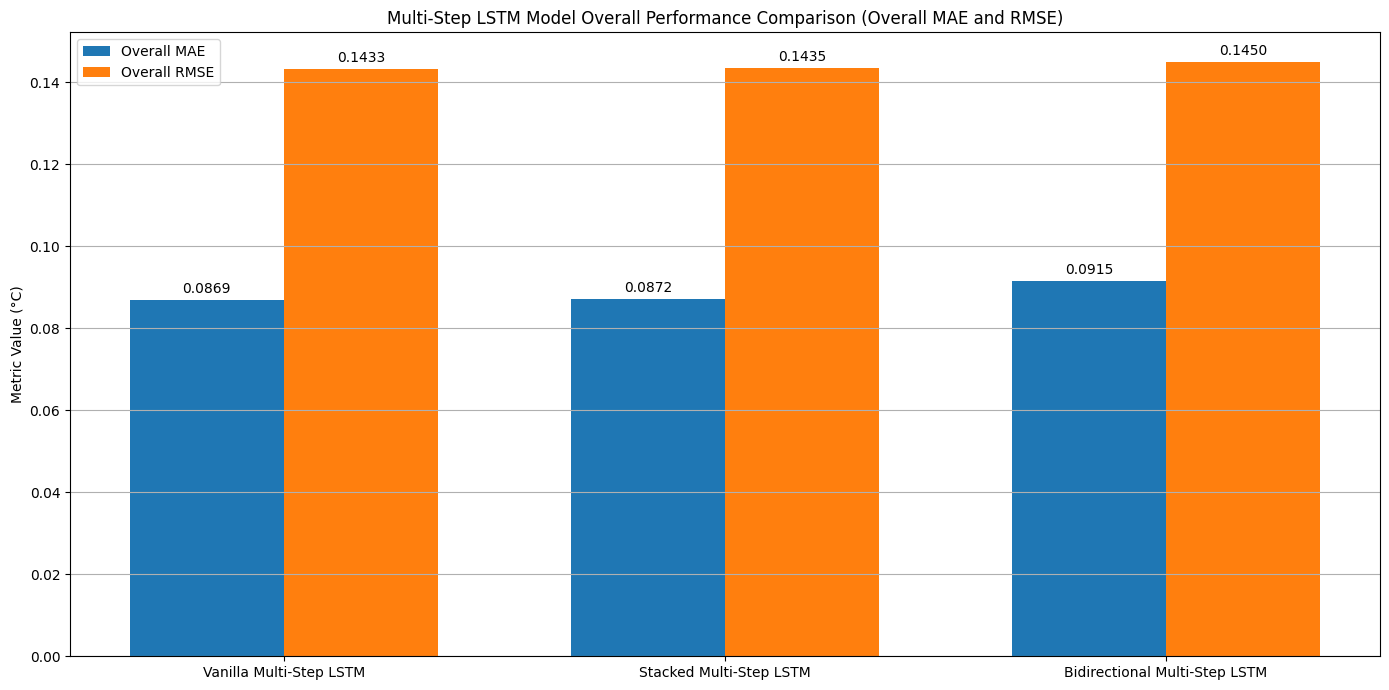

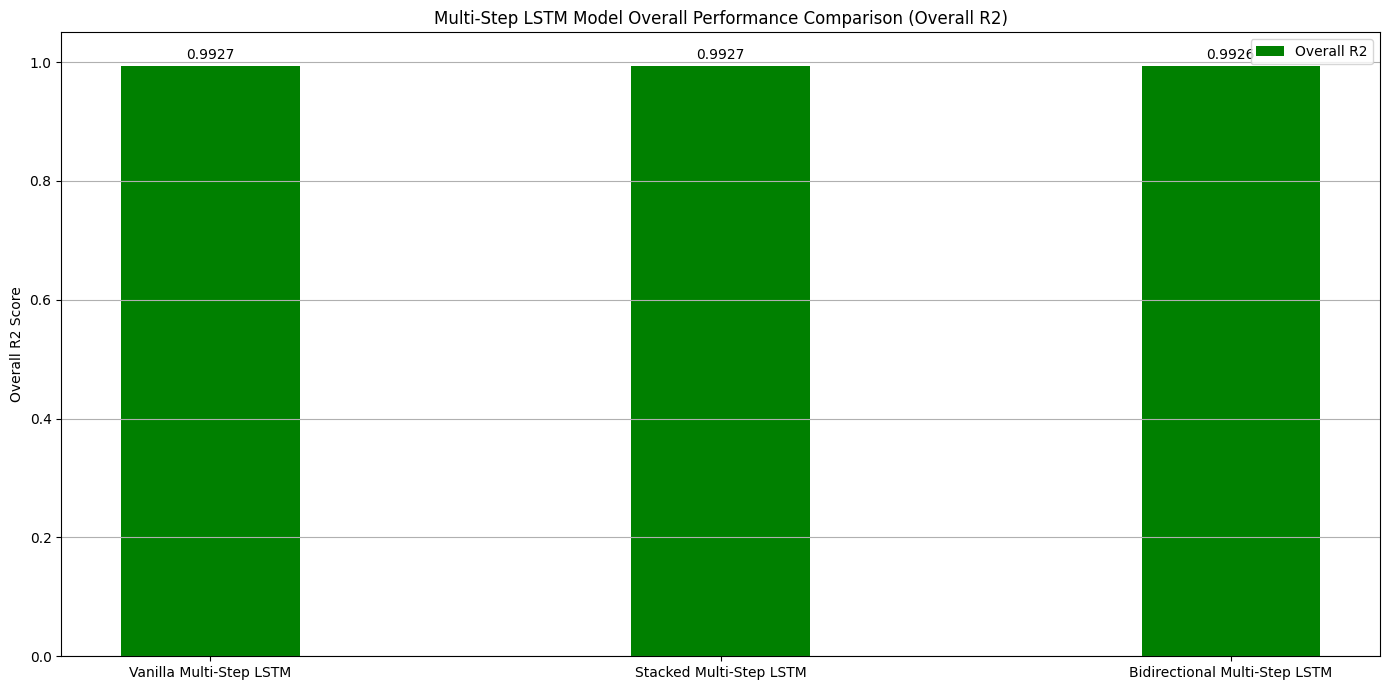




--- First 200 Points Predictions Comparison (Vanilla Multi-Step LSTM - First Forecast Step) ---


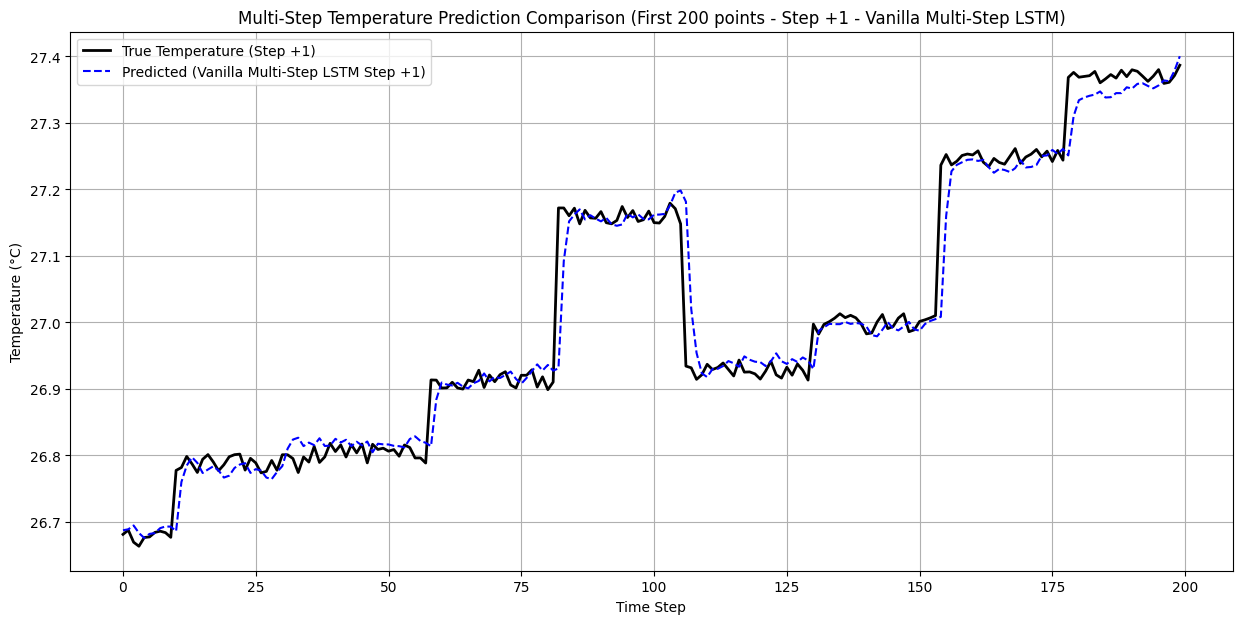


--- Complete Validation Set Predictions Comparison (Vanilla Multi-Step LSTM - First Forecast Step) ---


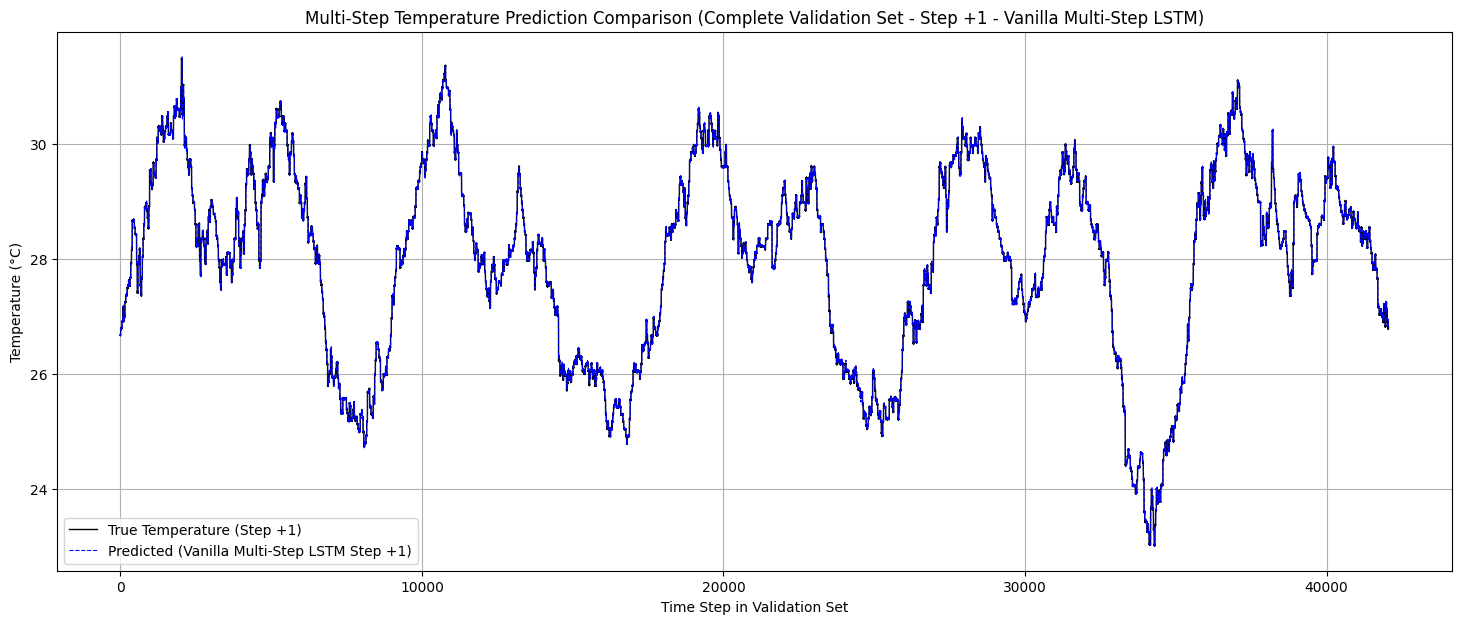


--- Scatter Plot: Predicted vs Observed (Multi-Step Models - Step +1) ---


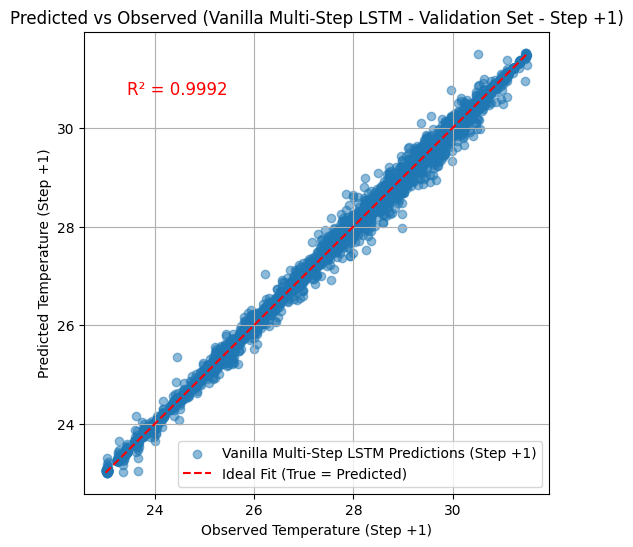

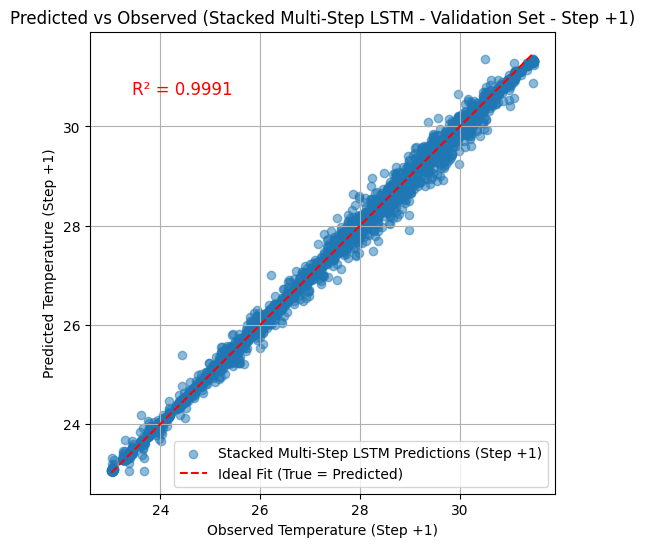

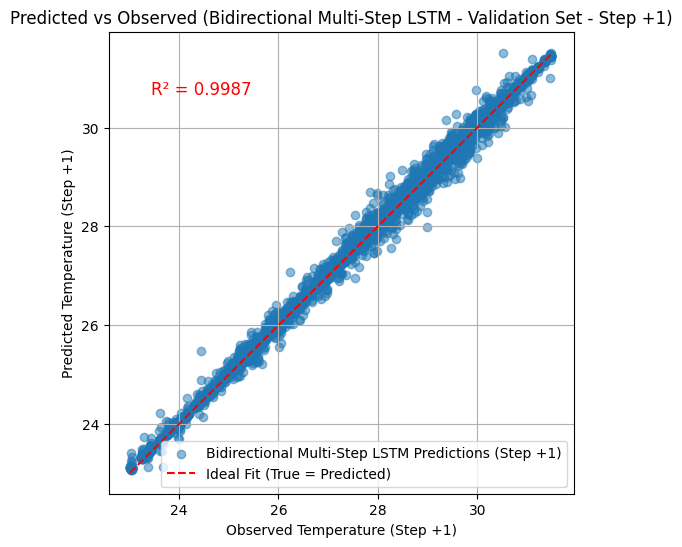


--- Making Future Multi-Step Forecast with the Selected Multi-Step Model ---
Using the selected multi-step model for forecasting: Vanilla Multi-Step LSTM
✅ Main scaler loaded successfully for multi-step forecasting from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model/scaler_temp_features.pkl.
✅ Data prepared for future multi-step forecasting. Input shape: (1, 24, 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Vanilla Multi-Step LSTM Multi-Step Forecast:
  2020-01-01 00:00:00: 26.5543°C
  2020-01-01 01:00:00: 26.5588°C
  2020-01-01 02:00:00: 26.5462°C
  2020-01-01 03:00:00: 26.5398°C
  2020-01-01 04:00:00: 26.5235°C
  2020-01-01 05:00:00: 26.5366°C
  2020-01-01 06:00:00: 26.5493°C
  2020-01-01 07:00:00: 26.5303°C
  2020-01-01 08:00:00: 26.5725°C
  2020-01-01 09:00:00: 26.5351°C
  2020-01-01 10:00:00: 26.5432°C
  2020-01-01 11:00:00: 26.5061°C
  2020-01-01 12:00:00: 26.5420°C
  2020-01-01 13:00:00: 26.5245°C
  2020-

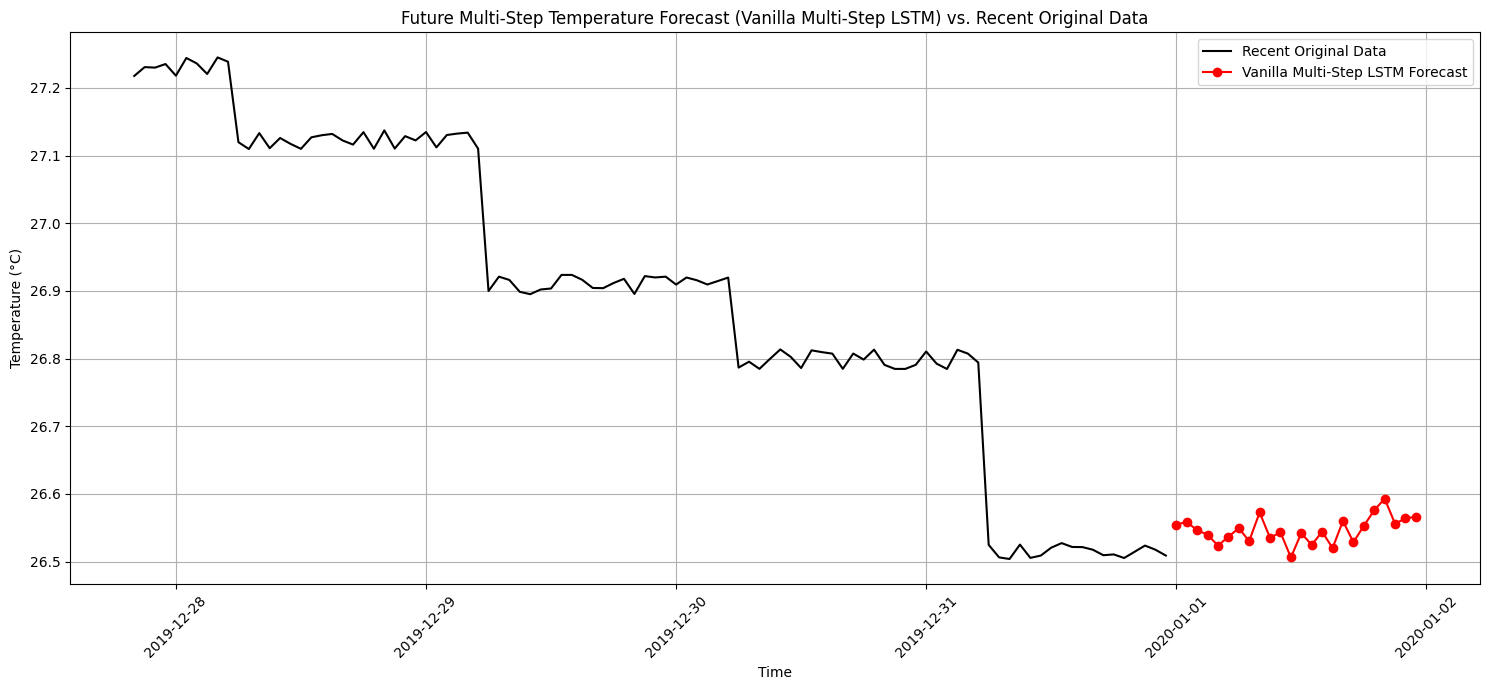

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pickle
import pandas as pd
import seaborn as sns

# Define the path to the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/multistep24_model"

# Define the file paths for models (using the requested naming convention)
model_vanilla_multi_file = os.path.join(multistep_model_path, 'vanilla_fnn24.h5')
model_stacked_multi_file = os.path.join(multistep_model_path, 'stacked_fnn24.h5')
model_bidirectional_multi_file = os.path.join(multistep_model_path, 'bidirectional_fnn24.h5')

# Define the path to the main scaler file (fitted on all 11 features)
# Assuming the scaler fitted on the data with all engineered features (11 features based on earlier cells) was saved with a similar naming convention.
# Adjust the scaler file name here if it's different.
main_scaler_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Temperature Data Analysis and Forecasting/model" # Example path, adjust as needed
main_scaler_file = os.path.join(main_scaler_path, 'scaler_temp_features.pkl') # Assuming the main 11-feature scaler file name


# Define features_for_multi_step_evaluation (should match the features used for multi-step training and evaluation - assumed 11 features)
# Dynamically get this from df_scaled_temp if available and correctly generated earlier to be sure
features_for_multi_step_evaluation = None
if 'df_scaled_temp' in locals() and df_scaled_temp is not None and not df_scaled_temp.empty:
     features_for_multi_step_evaluation = list(df_scaled_temp.columns)
     print(f"✅ 'features_for_multi_step_evaluation' list updated to match df_scaled_temp columns: {len(features_for_multi_step_evaluation)} features for multi-step evaluation.")
else:
    # Default to 11 features if df_scaled_temp is not available or has unexpected columns
    features_for_multi_step_evaluation = ['Temperature', 'Temperature_lag_24', 'Temperature_lag_48', 'Temperature_lag_72',
                                          'Temperature_rolling_mean', 'Temperature_rolling_std', 'hour', 'dayofweek',
                                          'dayofyear', 'month', 'year']
    print(f"✅ 'features_for_multi_step_evaluation' list set to {len(features_for_multi_step_evaluation)} features based on common engineered features for multi-step evaluation.")


# Define features_for_multi_step_forecasting (should match the features used to create X_forecast - typically the full set of 11)
features_for_multi_step_forecasting = features_for_multi_step_evaluation # Assuming the same features are used for forecasting


# --- Load Models and Scaler ---

models_multi_loaded = {} # Dictionary to store loaded multi-step models

# Load Vanilla Multi-Step Model
try:
    models_multi_loaded['Vanilla Multi-Step LSTM'] = load_model(model_vanilla_multi_file, custom_objects={'mse': MeanSquaredError()})
    print(f"✅ Vanilla Multi-Step model loaded successfully from {model_vanilla_multi_file}")
except Exception as e:
    print(f"Error loading Vanilla Multi-Step model: {e}. Skipping evaluation for this model.")

# Load Stacked Multi-Step Model
try:
    models_multi_loaded['Stacked Multi-Step LSTM'] = load_model(model_stacked_multi_file, custom_objects={'mse': MeanSquaredError()})
    print(f"✅ Stacked Multi-Step model loaded successfully from {model_stacked_multi_file}")
except Exception as e:
    print(f"Error loading Stacked Multi-Step model: {e}. Skipping evaluation for this model.")

# Load Bidirectional Multi-Step Model
try:
    models_multi_loaded['Bidirectional Multi-Step LSTM'] = load_model(model_bidirectional_multi_file, custom_objects={'mse': MeanSquaredError()})
    print(f"✅ Bidirectional Multi-Step model loaded successfully from {model_bidirectional_multi_file}")
except Exception as e:
    print(f"Error loading Bidirectional Multi-Step model: {e}. Skipping evaluation for this model.")


# Load the main scaler (fitted on 11 features) for multi-step evaluation and forecasting
scaler_loaded_multi = None
try:
    with open(main_scaler_file, 'rb') as f:
        scaler_loaded_multi = pickle.load(f)
    print(f"✅ Main scaler loaded successfully for multi-step forecasting from {main_scaler_file}.")
except Exception as e:
    print(f"FATAL Error: Could not load the main scaler from {main_scaler_file}: {e}. Cannot proceed with evaluation.")
    raise SystemExit("Scaler loading failed.")


# Ensure validation data is available (assuming X_val_multi_temp and y_val_multi_temp are in memory)
if 'X_val_multi_temp' not in locals() or 'y_val_multi_temp' not in locals():
     print("FATAL Error: Multi-step validation data (X_val_multi_temp, y_val_multi_temp) not found in memory. Please run data preparation steps.")
     raise SystemExit("Multi-step validation data not found.")

# Ensure at least one model was loaded
if not models_multi_loaded:
     print("FATAL Error: No multi-step models were loaded successfully. Cannot proceed with evaluation.")
     raise SystemExit("No multi-step models loaded.")

# Ensure features_for_multi_step_evaluation is correctly defined and matches the scaler's expected input shape
if features_for_multi_step_evaluation is None or len(features_for_multi_step_evaluation) != scaler_loaded_multi.n_features_in_:
     print(f"FATAL Error: 'features_for_multi_step_evaluation' list ({len(features_for_multi_step_evaluation) if features_for_multi_step_evaluation is not None else 'None'} features) does not match the loaded scaler's expected input features ({scaler_loaded_multi.n_features_in_}). Please check feature engineering and scaling steps.")
     raise SystemExit("Feature mismatch with scaler.")


# --- Inverse Transform True Values (only need to do this once) ---
# y_val_multi_temp contains scaled true values. Inverse transform them for metric calculation.
# Use features_for_multi_step_evaluation (11 features) for the dummy array for inverse transformation
dummy_true_array_temp = np.zeros((y_val_multi_temp.shape[0] * y_val_multi_temp.shape[1], len(features_for_multi_step_evaluation)))
dummy_true_array_temp[:, 0] = y_val_multi_temp.flatten()
y_true_multi_temp_orig = scaler_loaded_multi.inverse_transform(dummy_true_array_temp)[:, 0].reshape(y_val_multi_temp.shape)
print("✅ True multi-step validation values inverse transformed for metric calculation.")


# --- Make Predictions and Collect Results for Comparison ---

predictions_multi_orig = {} # Dictionary to store inverse transformed predictions for comparison

for model_name, model_loaded in models_multi_loaded.items():
     try:
          y_pred_multi_scaled = model_loaded.predict(X_val_multi_temp)

          # Inverse transform the prediction using the loaded main scaler (fitted on 11 features)
          dummy_pred_array_temp = np.zeros((y_pred_multi_scaled.shape[0] * y_pred_multi_scaled.shape[1], len(features_for_multi_step_evaluation))) # Use features_for_multi_step_evaluation (11) for dummy array
          dummy_pred_array_temp[:, 0] = y_pred_multi_scaled.flatten()
          predictions_multi_orig[model_name] = scaler_loaded_multi.inverse_transform(dummy_pred_array_temp)[:, 0].reshape(y_pred_multi_scaled.shape)
          print(f"✅ Predictions made for {model_name}.")


     except Exception as e:
          print(f"Error making predictions with {model_name}: {e}. Skipping predictions for this model.")


# --- Calculate and Compare Metrics for Each Step and Overall ---

step_metrics_multi = {} # Dictionary to store metrics per step for each model
overall_metrics_multi = {} # Dictionary to store overall metrics for each model

if y_true_multi_temp_orig is not None and predictions_multi_orig: # Ensure true values and at least one prediction exist
    for model_name, y_pred_orig in predictions_multi_orig.items():
        step_metrics_multi[model_name] = []
        for i in range(y_pred_orig.shape[1]):
            mae = mean_absolute_error(y_true_multi_temp_orig[:, i], y_pred_orig[:, i])
            rmse = np.sqrt(mean_squared_error(y_true_multi_temp_orig[:, i], y_pred_orig[:, i]))
            r2 = r2_score(y_true_multi_temp_orig[:, i], y_pred_orig[:, i])
            step_metrics_multi[model_name].append((mae, rmse, r2))

        overall_mae = mean_absolute_error(y_true_multi_temp_orig.flatten(), y_pred_orig.flatten())
        overall_rmse = np.sqrt(mean_squared_error(y_true_multi_temp_orig.flatten(), y_pred_orig.flatten()))
        overall_r2 = r2_score(y_true_multi_temp_orig.flatten(), y_pred_orig.flatten())
        overall_metrics_multi[model_name] = {'MAE': overall_mae, 'RMSE': overall_rmse, 'R2': overall_r2}

        print(f"\n{model_name} Multi-Step Evaluation Metrics:")
        for i, (mae, rmse, r2) in enumerate(step_metrics_multi[model_name]):
             print(f"  Step +{i+1}: MAE={mae:.4f}°C, RMSE={rmse:.4f}°C, R2={r2:.4f}")
        print(f"  Overall: MAE={overall_metrics_multi[model_name]['MAE']:.4f}°C, RMSE={overall_metrics_multi[model_name]['RMSE']:.4f}°C, R2={overall_metrics_multi[model_name]['R2']:.4f}")

elif predictions_multi_orig:
    print("\nSkipping multi-step metric calculation as true values are not available.")
else:
    print("\nSkipping multi-step metric calculation as no predictions were made.")


# --- Visualize Overall Performance Comparison ---

if overall_metrics_multi:
    model_names = list(overall_metrics_multi.keys())
    x = np.arange(len(model_names)) # the label locations
    width = 0.35 # the width of the bars

    # Plot Overall MAE and RMSE
    fig_mae_rmse, ax_mae_rmse = plt.subplots(figsize=(14, 7))
    rects_mae = ax_mae_rmse.bar(x - width/2, [overall_metrics_multi[name]['MAE'] for name in model_names], width, label='Overall MAE')
    rects_rmse = ax_mae_rmse.bar(x + width/2, [overall_metrics_multi[name]['RMSE'] for name in model_names], width, label='Overall RMSE')

    ax_mae_rmse.set_ylabel('Metric Value (°C)')
    ax_mae_rmse.set_title('Multi-Step LSTM Model Overall Performance Comparison (Overall MAE and RMSE)')
    ax_mae_rmse.set_xticks(x)
    ax_mae_rmse.set_xticklabels(model_names)
    ax_mae_rmse.legend()
    ax_mae_rmse.grid(True, axis='y')

    def autolabel(rects, ax):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.4f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects_mae, ax_mae_rmse)
    autolabel(rects_rmse, ax_mae_rmse)
    fig_mae_rmse.tight_layout()
    plt.show()

    # Plot Overall R2
    fig_r2, ax_r2 = plt.subplots(figsize=(14, 7))
    rects_r2 = ax_r2.bar(x, [overall_metrics_multi[name]['R2'] for name in model_names], width, label='Overall R2', color='green')

    ax_r2.set_ylabel('Overall R2 Score')
    ax_r2.set_title('Multi-Step LSTM Model Overall Performance Comparison (Overall R2)')
    ax_r2.set_xticks(x)
    ax_r2.set_xticklabels(model_names)
    ax_r2.legend()
    ax_r2.grid(True, axis='y')
    ax_r2.set_ylim(0, 1.05) # R2 is typically between 0 and 1

    autolabel(rects_r2, ax_r2)
    fig_r2.tight_layout()
    plt.show()

else:
     print("\nSkipping overall multi-step performance comparison visualization as no metrics were available.")

print()


# --- Visualize Error Progression by Step (Removed as requested) ---


# --- Plot Training History for each model (Removed as requested) ---
# Removed training history plots as requested

print()


# --- Visualize Sample Predictions Comparison (e.g., first 5 sequences) (Removed as requested) ---


# --- Add Plot for First 200 Points of Predictions for the Best Model (Vanilla Multi-Step LSTM) ---
selected_model_for_plots = "Vanilla Multi-Step LSTM"
if selected_model_for_plots in predictions_multi_orig and y_true_multi_temp_orig is not None:
    print(f"\n--- First 200 Points Predictions Comparison ({selected_model_for_plots} - First Forecast Step) ---")
    plt.figure(figsize=(15, 7))
    plt.plot(y_true_multi_temp_orig[:200, 0], label='True Temperature (Step +1)', color='black', linewidth=2) # Plot true values for the first step

    y_pred_orig_multi = predictions_multi_orig[selected_model_for_plots]
    plt.plot(y_pred_orig_multi[:200, 0], label=f'Predicted ({selected_model_for_plots} Step +1)', color='blue', linestyle='--')

    plt.title(f'Multi-Step Temperature Prediction Comparison (First 200 points - Step +1 - {selected_model_for_plots})')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"\nSkipping first 200 points prediction comparison visualization for {selected_model_for_plots} as predictions are not available.")

# --- Add Plot for Complete Validation Set Comparison (First Forecast Step) for the Best Model (Vanilla Multi-Step LSTM) ---
if selected_model_for_plots in predictions_multi_orig and y_true_multi_temp_orig is not None:
    print(f"\n--- Complete Validation Set Predictions Comparison ({selected_model_for_plots} - First Forecast Step) ---")
    plt.figure(figsize=(18, 7))

    # Plot true values for the first step of the complete validation set
    plt.plot(y_true_multi_temp_orig[:, 0], label='True Temperature (Step +1)', color='black', linewidth=1)

    y_pred_orig_multi = predictions_multi_orig[selected_model_for_plots]
    # Plot the first forecast step prediction for the complete validation set
    plt.plot(y_pred_orig_multi[:, 0], label=f'Predicted ({selected_model_for_plots} Step +1)', color='blue', linestyle='--', linewidth=0.8)

    plt.title(f'Multi-Step Temperature Prediction Comparison (Complete Validation Set - Step +1 - {selected_model_for_plots})')
    plt.xlabel('Time Step in Validation Set')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"\nSkipping complete validation set prediction comparison visualization for {selected_model_for_plots} as predictions are not available.")


# --- Add Scatter Plot: Predicted vs Observed (Multi-Step Models - Step +1) ---
if y_true_multi_temp_orig is not None and predictions_multi_orig and 'out_length_temp' in locals() and out_length_temp > 0:
    print("\n--- Scatter Plot: Predicted vs Observed (Multi-Step Models - Step +1) ---")
    for model_name, y_pred_orig in predictions_multi_orig.items(): # This loop will run for all loaded models
        try:
            # Ensure y_true and y_pred for the first step have the same shape
            if y_true_multi_temp_orig[:, 0].shape == y_pred_orig[:, 0].shape:
                r2 = r2_score(y_true_multi_temp_orig[:, 0], y_pred_orig[:, 0])

                plt.figure(figsize=(6, 6))
                plt.scatter(y_true_multi_temp_orig[:, 0], y_pred_orig[:, 0], alpha=0.5, label=f'{model_name} Predictions (Step +1)') # Added label for scatter points
                # Plotting the ideal fit line (y=x)
                min_val = min(y_true_multi_temp_orig[:, 0].min(), y_pred_orig[:, 0].min()) if y_true_multi_temp_orig[:, 0].size > 0 and y_pred_orig[:, 0].size > 0 else 0
                max_val = max(y_true_multi_temp_orig[:, 0].max(), y_pred_orig[:, 0].max()) if y_true_multi_temp_orig[:, 0].size > 0 and y_pred_orig[:, 0].size > 0 else 1
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (True = Predicted)') # Added label for ideal fit line

                plt.xlabel("Observed Temperature (Step +1)")
                plt.ylabel("Predicted Temperature (Step +1)")
                plt.title(f"Predicted vs Observed ({model_name} - Validation Set - Step +1)")
                plt.legend() # Added legend call
                # Position R2 annotation relative to plot limits
                x_pos = min_val + (max_val - min_val) * 0.05 # 5% from left
                y_pos = max_val - (max_val - min_val) * 0.1 # 10% from top
                plt.annotate(f'R² = {r2:.4f}', xy=(x_pos, y_pos), fontsize=12, color='red')

                plt.grid(True)
                plt.show()
            else:
                print(f"Skipping scatter plot for {model_name} (Step +1) due to shape mismatch.")

        except Exception as e:
            print(f"Error generating scatter plot for {model_name} (Step +1): {e}")
else:
    print("\nSkipping scatter plot for multi-step models as true values, predictions, or out_length_temp are not available.")


# --- Make Future Forecasts with the Selected Multi-Step Model ---
print("\n--- Making Future Multi-Step Forecast with the Selected Multi-Step Model ---")

# Specify the model name to use for the future forecast plot
selected_model_multi_step_forecast = "Vanilla Multi-Step LSTM" # Use Vanilla for forecasting as well

if selected_model_multi_step_forecast is not None and selected_model_multi_step_forecast in models_multi_loaded:
    selected_model_loaded_multi = models_multi_loaded[selected_model_multi_step_forecast]
    print(f"Using the selected multi-step model for forecasting: {selected_model_multi_step_forecast}")

    # Assuming df_temp is your original DataFrame with engineered features, sorted by time.
    # You need the last 'seq_len_multi' data points from the DataFrame with engineered features.
    seq_len_multi = X_train_multi_temp.shape[1] # This should be the same as inp_length_temp


    # Load the main scaler (fitted on 11 features) specifically for forecasting
    main_scaler_for_forecast_multi = None
    try:
        with open(main_scaler_file, 'rb') as f: # Using the updated main_scaler_file name
             main_scaler_for_forecast_multi = pickle.load(f)
        print(f"✅ Main scaler loaded successfully for multi-step forecasting from {main_scaler_file}.")
    except Exception as e:
        print(f"Error: Could not load the main scaler for multi-step forecasting from {main_scaler_file}: {e}. Cannot prepare data for forecasting.")
        main_scaler_for_forecast_multi = None


    if main_scaler_for_forecast_multi is not None:
        # Check if df_temp exists and is not empty before proceeding with data preparation
        if 'df_temp' in locals() and not df_temp.empty:
            # Ensure the DataFrame is sorted by time
            df_temp.sort_index(inplace=True)

            # Get the last sequence for forecasting input using the full set of features (11 features)
            last_sequence_multi = df_temp[features_for_multi_step_forecasting].tail(seq_len_multi)
            if last_sequence_multi.isnull().any().any():
                 print("Warning: NaNs found in the last sequence used for multi-step forecasting.")

            # Scale the last sequence using the MAIN loaded scaler (fitted on 11 features)
            last_sequence_multi_scaled = main_scaler_for_forecast_multi.transform(last_sequence_multi)
            # Reshape for LSTM input (1 sample, time steps, features)
            X_forecast_multi = last_sequence_multi_scaled.reshape(1, seq_len_multi, len(features_for_multi_step_forecasting))
            print(f"✅ Data prepared for future multi-step forecasting. Input shape: {X_forecast_multi.shape}")

        else:
            print("Error: DataFrame 'df_temp' is not loaded or is empty. Please ensure data loading and preprocessing were successful.")
            X_forecast_multi = None

    else:
        print("\nSkipping future multi-step forecasts due to main scaler loading issues.")
        X_forecast_multi = None


    if X_forecast_multi is not None and main_scaler_for_forecast_multi is not None: # Use main_scaler_for_forecast_multi here
        last_timestamp = df_temp.index[-1]
        forecast_horizon = y_train_multi_temp.shape[1] # Should be the same as out_length_temp
        forecast_timestamps = [last_timestamp + pd.Timedelta(hours=i+1) for i in range(forecast_horizon)] # Timestamps for the forecast horizon

        try:
           predictions_scaled_multi = selected_model_loaded_multi.predict(X_forecast_multi)

           # Inverse transform the multi-step prediction sequence using the MAIN scaler fitted on 11 features
           dummy_predictions_array_multi = np.zeros((predictions_scaled_multi.shape[0] * predictions_scaled_multi.shape[1], len(features_for_multi_step_evaluation))) # Use features_for_step_evaluation (11) for dummy array
           dummy_predictions_array_multi[:, 0] = predictions_scaled_multi.flatten()
           predictions_orig_multi = main_scaler_for_forecast_multi.inverse_transform(dummy_predictions_array_multi)[:, 0].reshape(predictions_scaled_multi.shape) # Use main_scaler_for_forecast_multi

           print(f"\n{selected_model_multi_step_forecast} Multi-Step Forecast:")
           for i, timestamp in enumerate(forecast_timestamps):
                 print(f"  {timestamp}: {predictions_orig_multi[0, i]:.4f}°C")

           # --- Plot Future Forecast vs Original Data (Multi-Step) ---
           print("\n--- Plotting Future Forecast vs Original Data (Selected Multi-Step Model) ---")

           # Get a recent portion of the original data to plot alongside the forecast
           # Let's plot the last 100 data points from the original df_temp
           recent_original_data_multi = df_temp['Temperature'].tail(100)

           plt.figure(figsize=(15, 7))

           # Plot the recent original data
           plt.plot(recent_original_data_multi.index, recent_original_data_multi.values, label='Recent Original Data', color='black')

           # Plot the multi-step forecast sequence
           plt.plot(forecast_timestamps, predictions_orig_multi[0], 'ro-', label=f'{selected_model_multi_step_forecast} Forecast') # 'ro-' for red circles connected by a line

           plt.title(f'Future Multi-Step Temperature Forecast ({selected_model_multi_step_forecast}) vs. Recent Original Data')
           plt.xlabel('Time')
           plt.ylabel('Temperature (°C)')
           plt.legend()
           plt.grid(True)
           plt.xticks(rotation=45)
           plt.tight_layout()
           plt.show()


        except Exception as e:
             print(f"Error making multi-step forecast with {selected_model_multi_step_forecast}: {e}")
else:
     print(f"\nSkipping future multi-step forecast plot as the selected model '{selected_model_multi_step_forecast}' could not be loaded.")